# Chapter 1 Code Notebook

## 0. General Imports

In [1]:
import os

import numpy as np
import pandas as pd

import tensorflow as tf
from tensorflow import keras


import matplotlib.pyplot as plt
import cv2


from tqdm.notebook import tqdm

## 1. Loading the Dataset

In [2]:
(X_train, y_train), (X_test, y_test) = keras.datasets.cifar10.load_data()

# can be used to truncate small for speed and memory convenience
# original size is 50_000 samples
TRAIN_SAMPLES = None
X_train = X_train[:TRAIN_SAMPLES]
y_train = y_train[:TRAIN_SAMPLES]

170508288/170498071 [==============================] - 3s 0us/step


Let's visualize some of the samples.

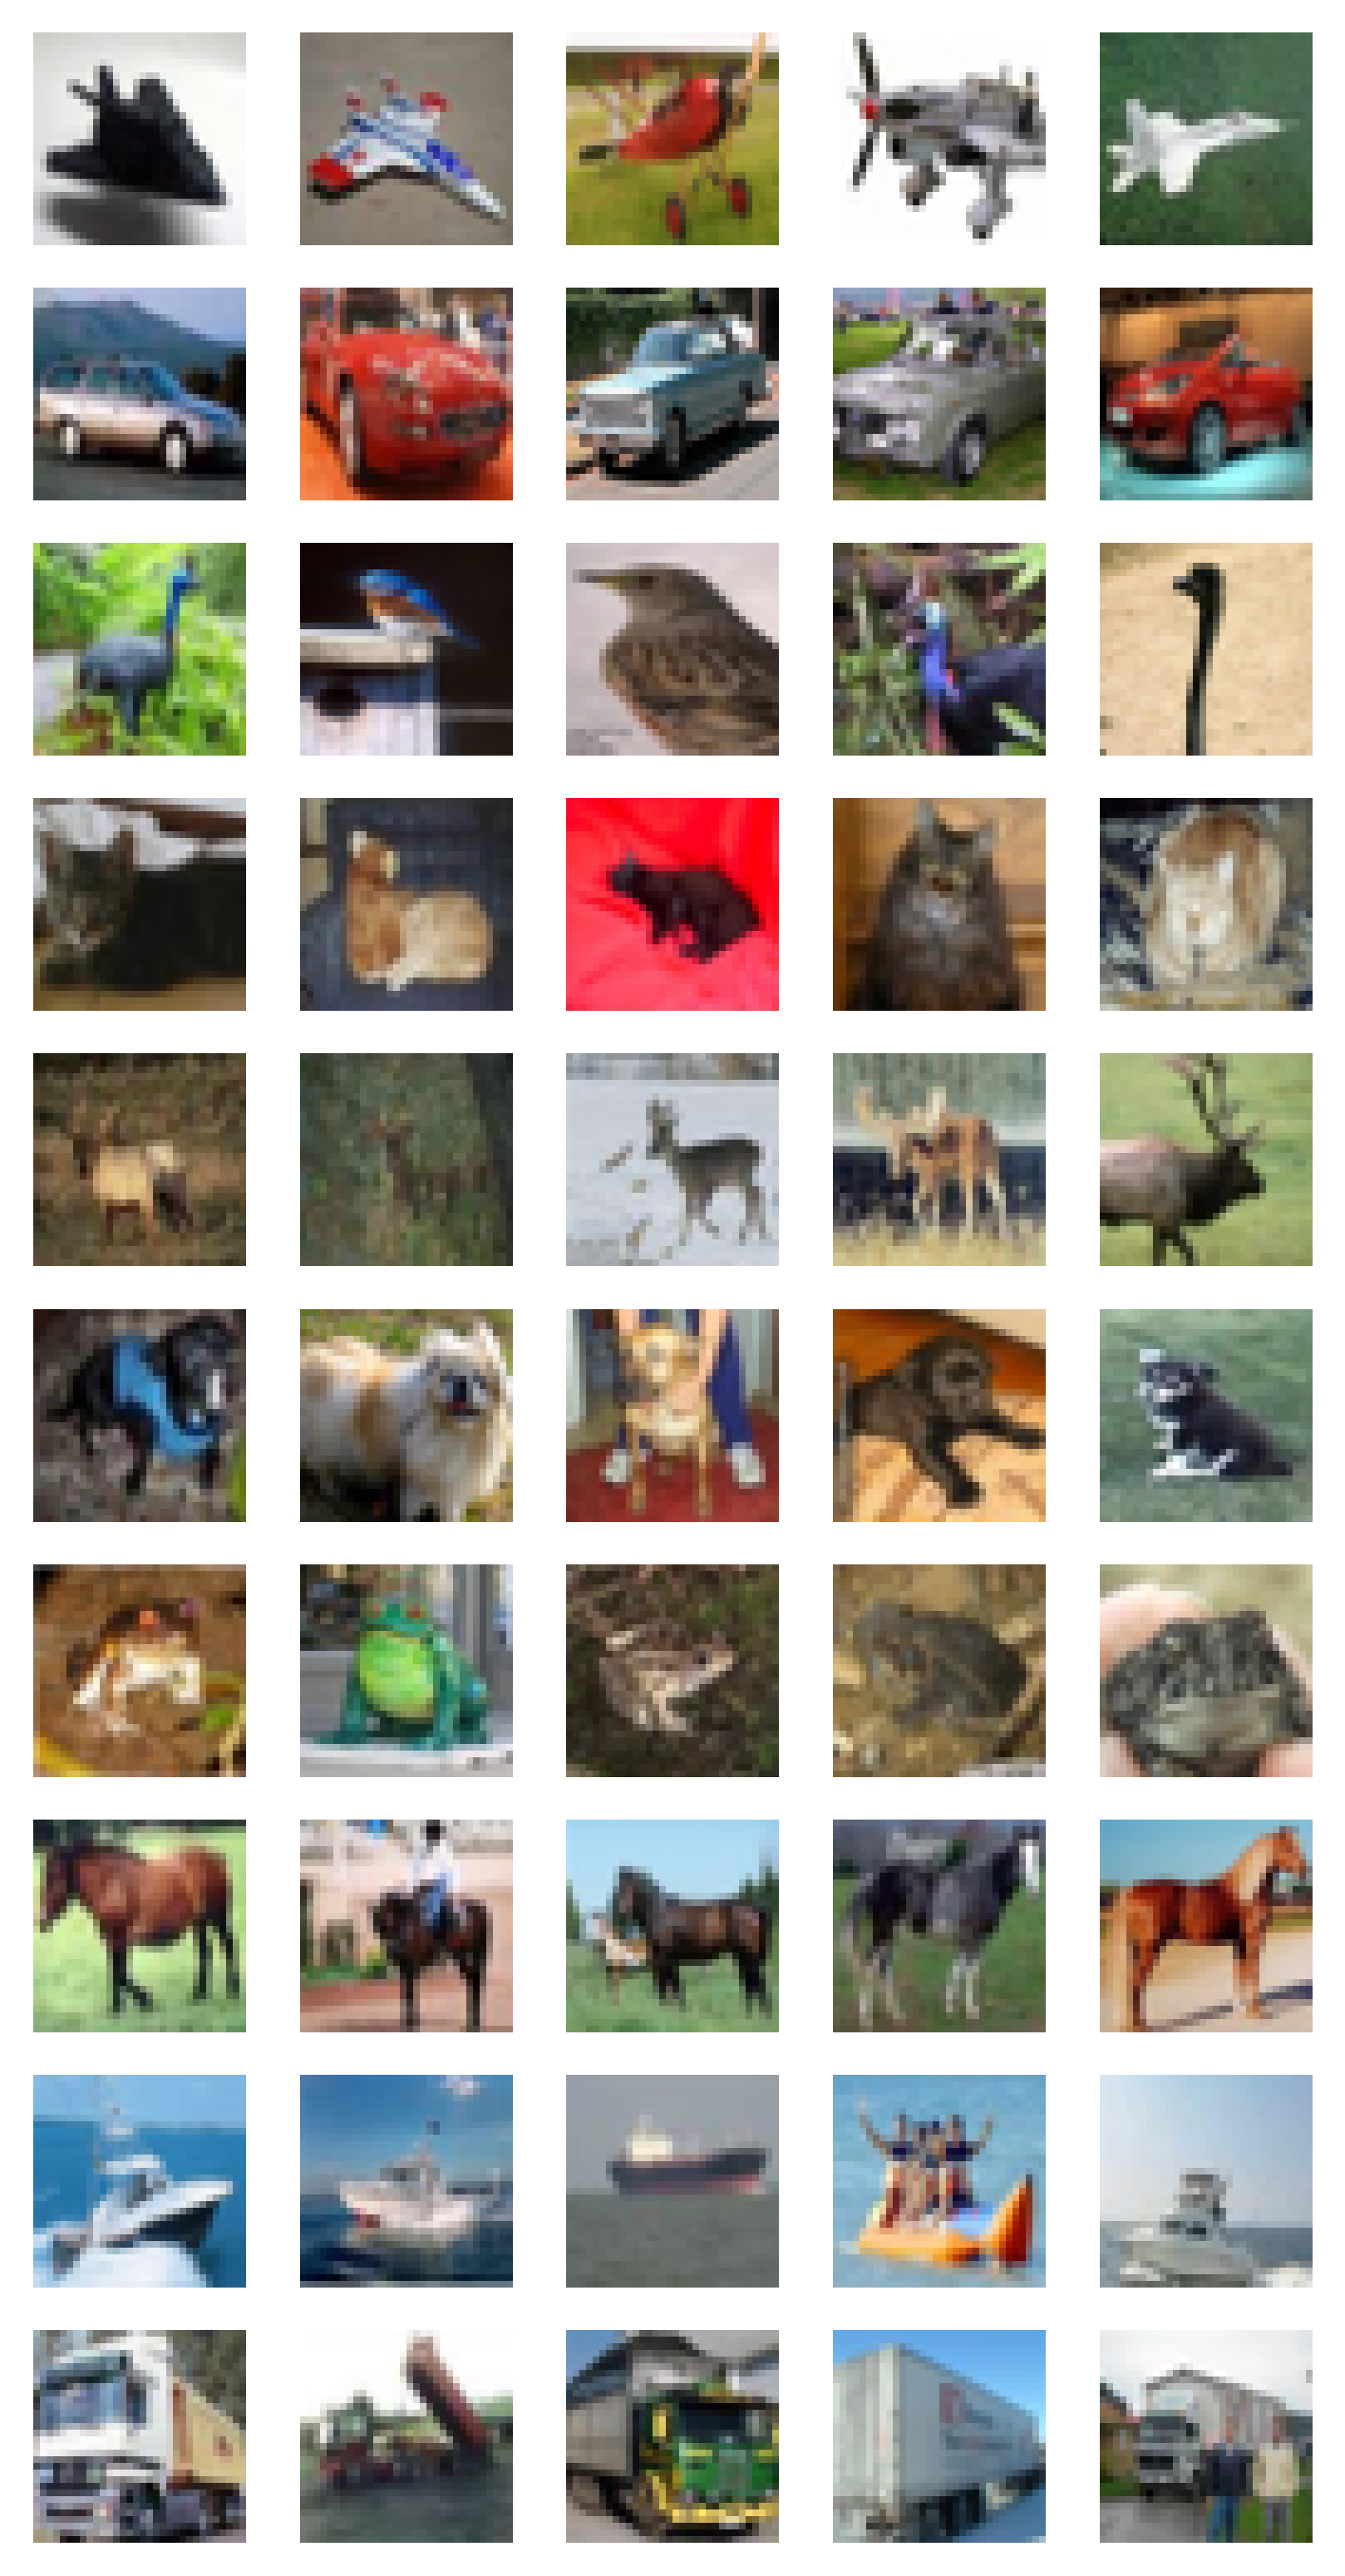

In [3]:
plt.figure(figsize=(5, 10), dpi=400)
for i in range(10):
    samples = X_train[np.squeeze(y_train == i)][:5]
    for j in range(5):
        plt.subplot(10, 5, i*5 + j + 1)
        plt.imshow(samples[j])
        plt.axis('off')
plt.show()
plt.close()

## 2. Teacher ranking

In [4]:
from keras import layers as L

NUM_BLOCKS = 4
STARTING_EXP = 3

inp = L.Input((32, 32, 3))
x = inp
for i in range(NUM_BLOCKS):
    x = L.Conv2D(2**(i+STARTING_EXP), (3, 3), activation='relu', padding='same')(x)
    x = L.Conv2D(2**(i+STARTING_EXP), (3, 3), activation='relu', padding='same')(x)
    x = L.MaxPooling2D((2, 2))(x)
x = L.Flatten()(x)
out = L.Dense(10, activation='softmax')(x)

model = keras.models.Model(inputs=inp, outputs=out)

2022-12-11 20:27:52.044075: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-11 20:27:52.138621: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-11 20:27:52.139487: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-11 20:27:52.141923: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

In [5]:
# keras.utils.plot_model(model, show_shapes=True, dpi=400)

In [6]:
# model.summary()

In [7]:
scaled_X_train = X_train / 255

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.fit(scaled_X_train, y_train, epochs=30)

2022-12-11 20:27:57.209210: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/30


2022-12-11 20:27:58.661584: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


1563/1563 [==============================] - 15s 5ms/step - loss: 1.6267 - accuracy: 0.4004
Epoch 2/30
1563/1563 [==============================] - 7s 5ms/step - loss: 1.2315 - accuracy: 0.5558
Epoch 3/30
1563/1563 [==============================] - 8s 5ms/step - loss: 1.0488 - accuracy: 0.6271
Epoch 4/30
1563/1563 [==============================] - 8s 5ms/step - loss: 0.9400 - accuracy: 0.6681
Epoch 5/30
1563/1563 [==============================] - 8s 5ms/step - loss: 0.8599 - accuracy: 0.6969
Epoch 6/30
1563/1563 [==============================] - 8s 5ms/step - loss: 0.7935 - accuracy: 0.7204
Epoch 7/30
1563/1563 [==============================] - 7s 5ms/step - loss: 0.7359 - accuracy: 0.7406
Epoch 8/30
1563/1563 [==============================] - 7s 5ms/step - loss: 0.6862 - accuracy: 0.7580
Epoch 9/30
1563/1563 [==============================] - 8s 5ms/step - loss: 0.6467 - accuracy: 0.7710
Epoch 10/30
1563/1563 [==============================] - 7s 5ms/step - loss: 0.6067 - accura

In [8]:
scce = keras.losses.SparseCategoricalCrossentropy(reduction='none')
losses = scce(y_train, model.predict(scaled_X_train)).numpy()

In [9]:
order_X_train = X_train[np.argsort(losses)]
order_losses = losses[np.argsort(losses)]

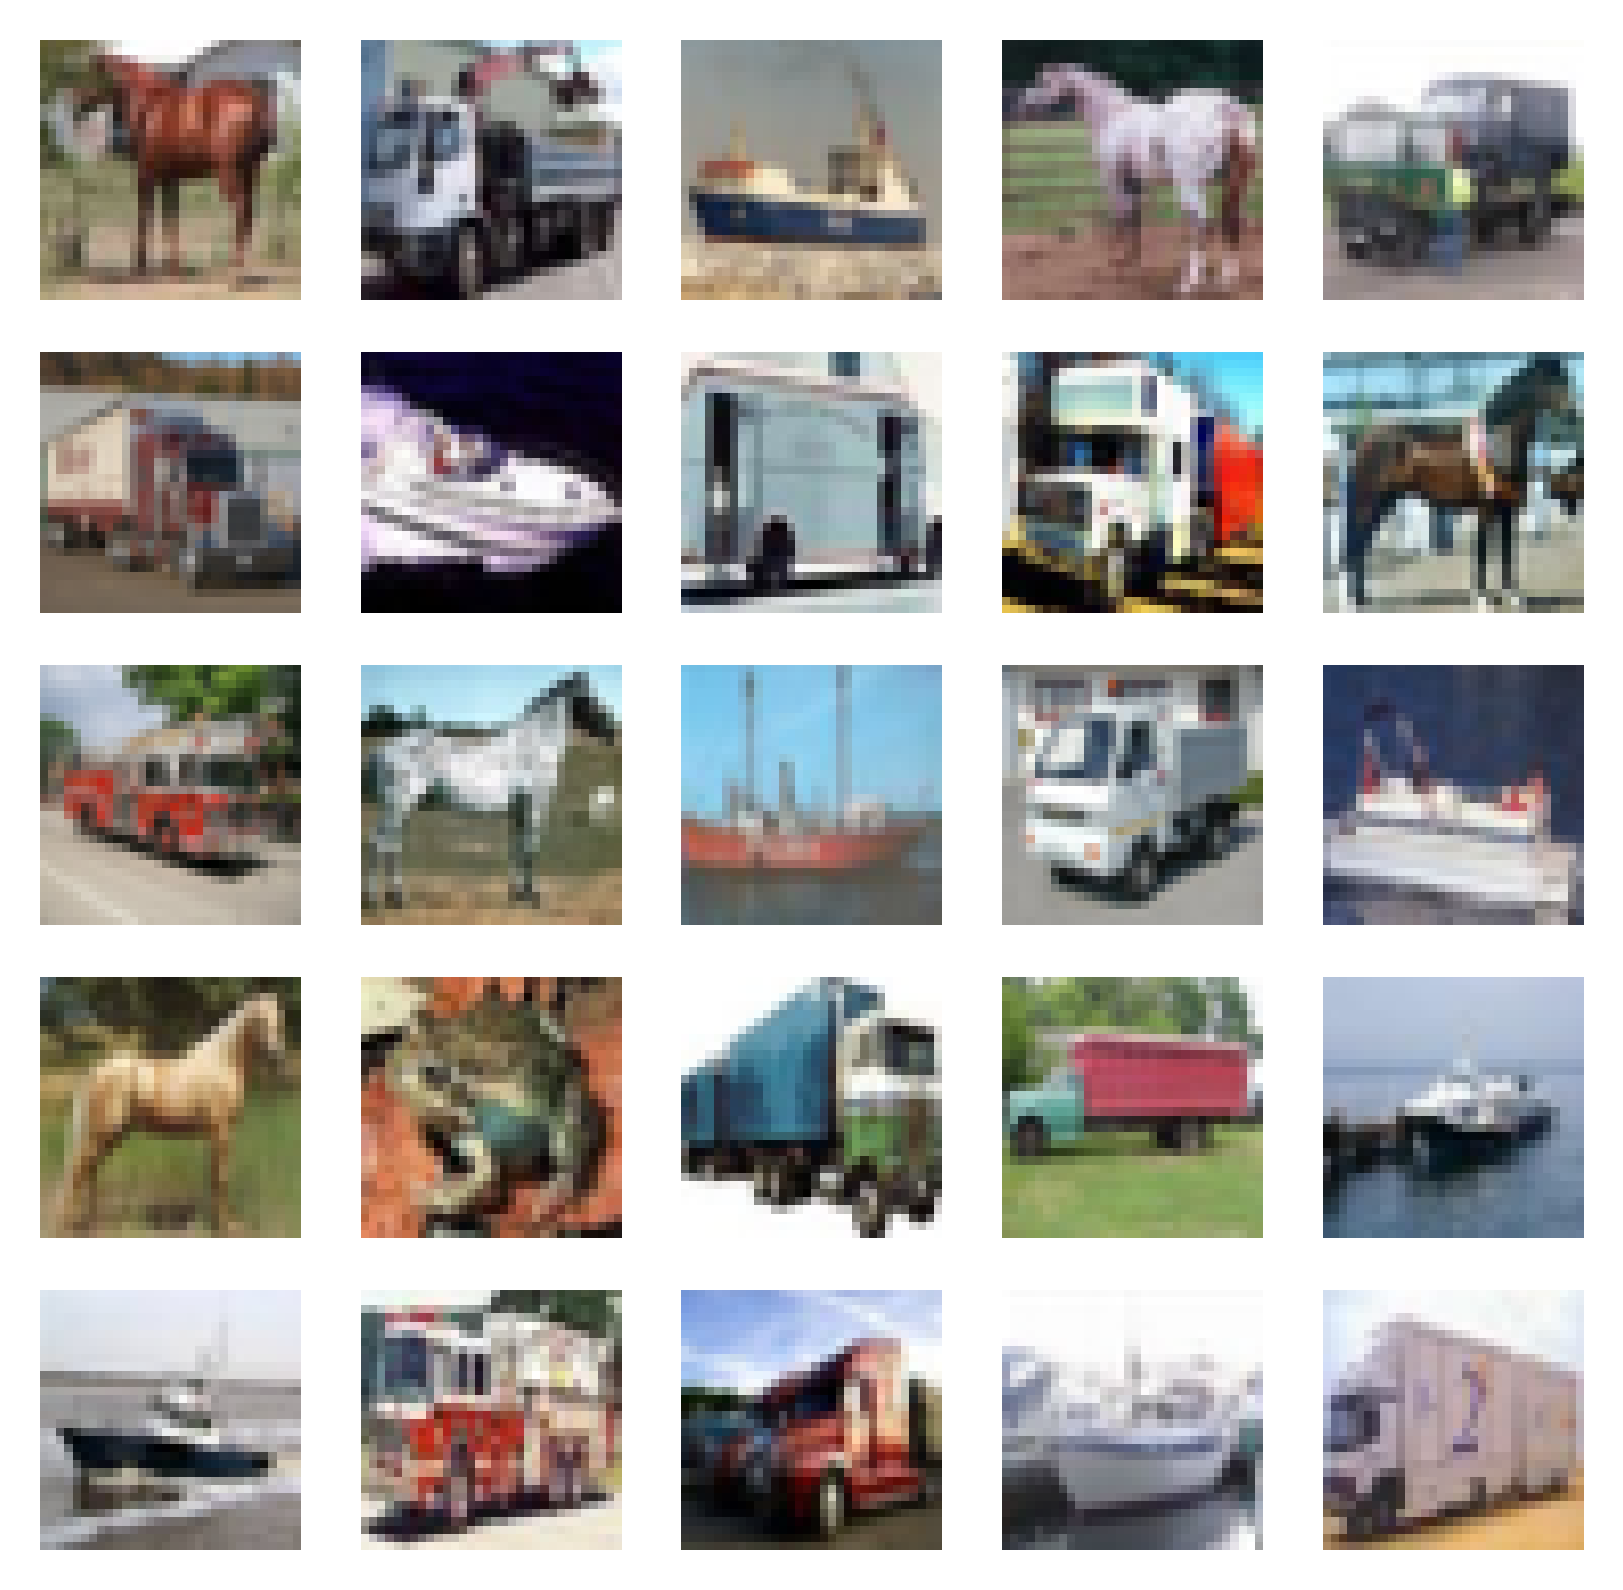

In [10]:
plt.figure(figsize=(5, 5), dpi=400)
for i in range(5):
    for j in range(5):
        plt.subplot(5, 5, i*5 + j + 1)
        plt.imshow(order_X_train[i*5 + j])
        plt.axis('off')
plt.show()
plt.close()

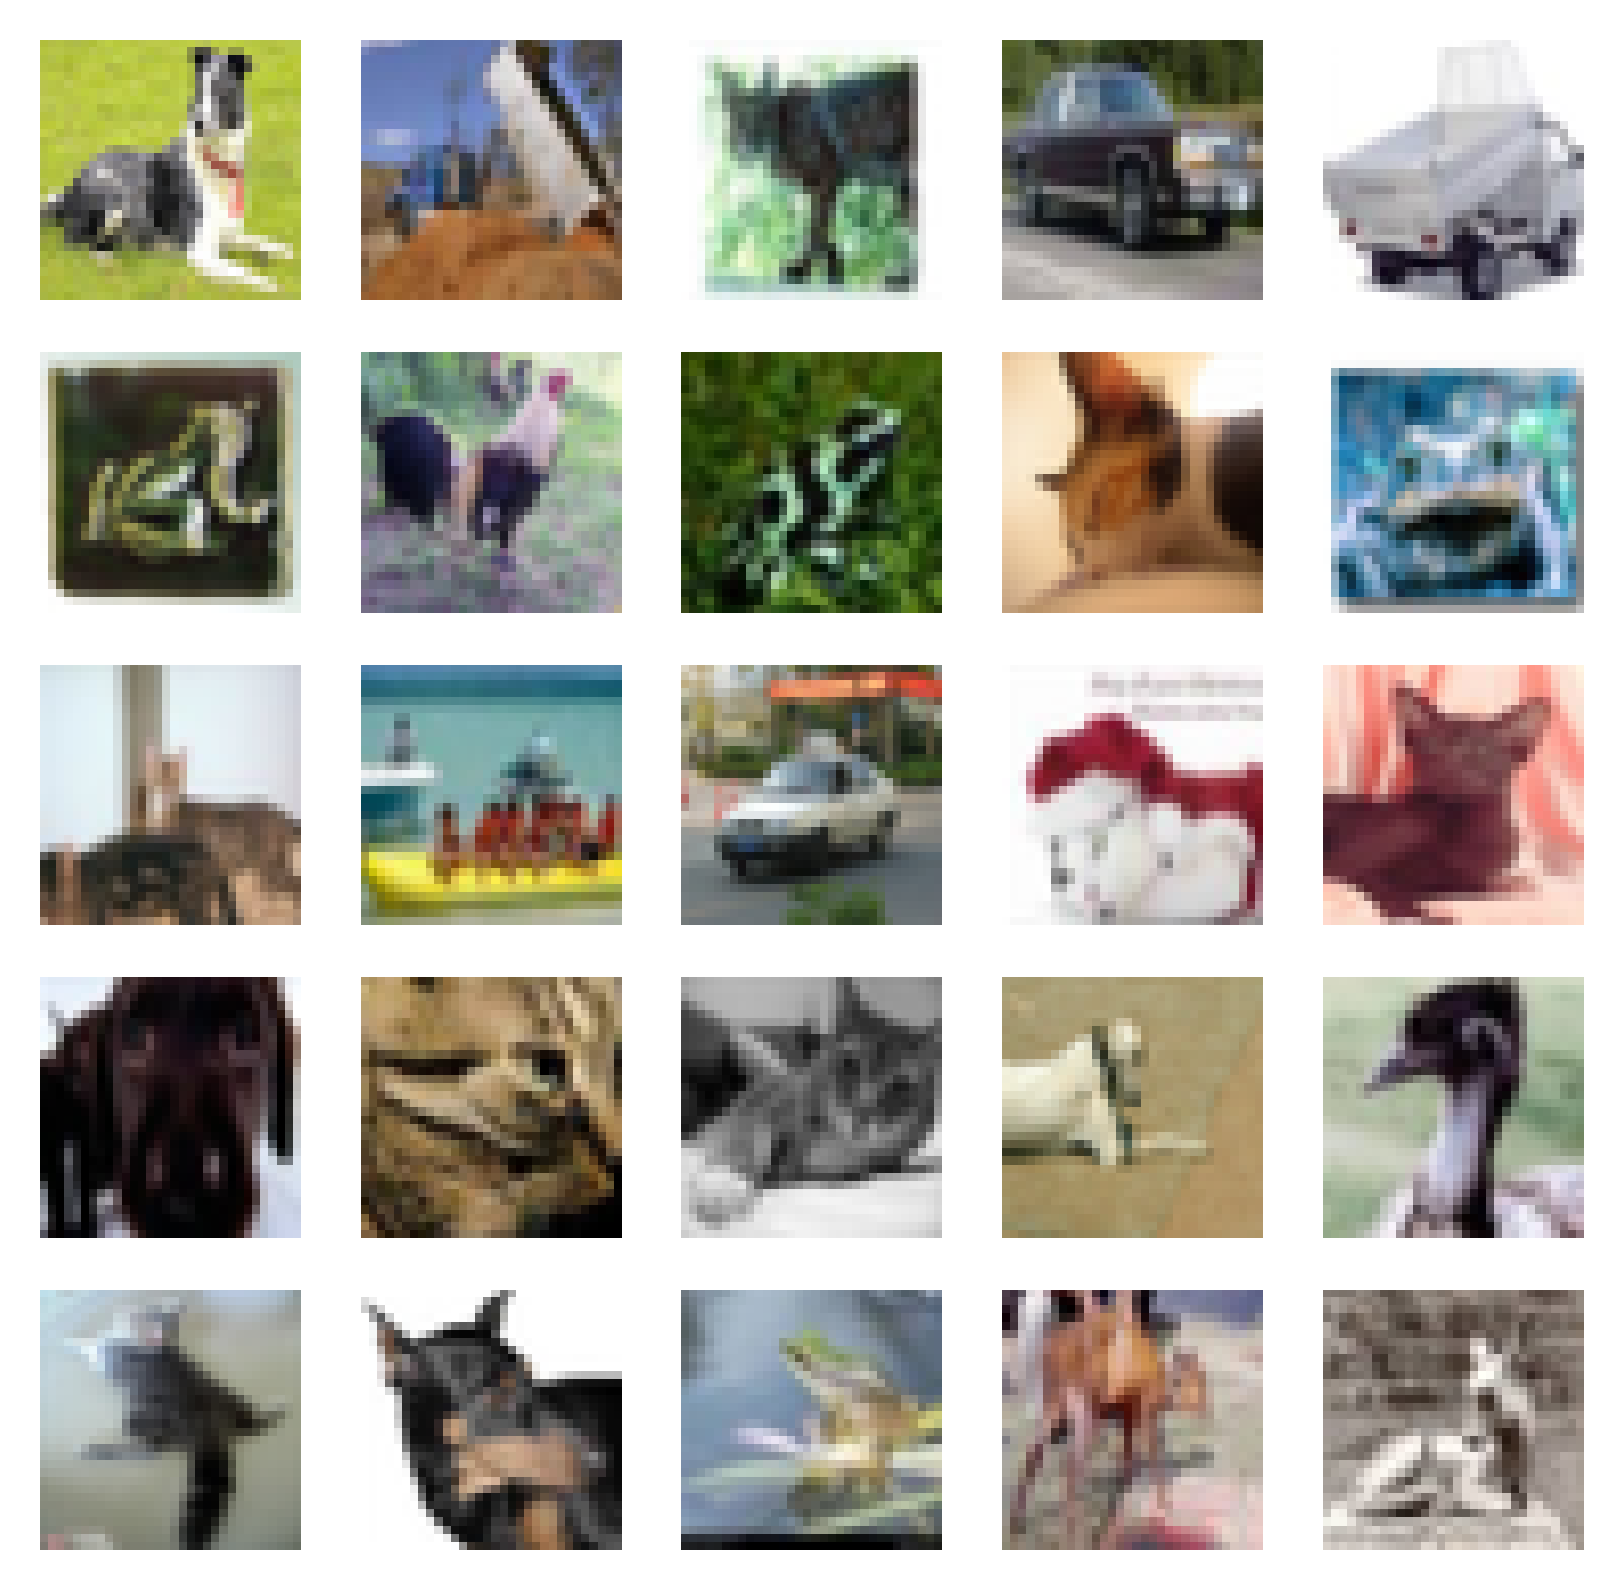

In [11]:
plt.figure(figsize=(5, 5), dpi=400)
for i in range(5):
    for j in range(5):
        plt.subplot(5, 5, i*5 + j + 1)
        plt.imshow(order_X_train[- (i*5 + j + 1)])
        plt.axis('off')
plt.show()
plt.close()

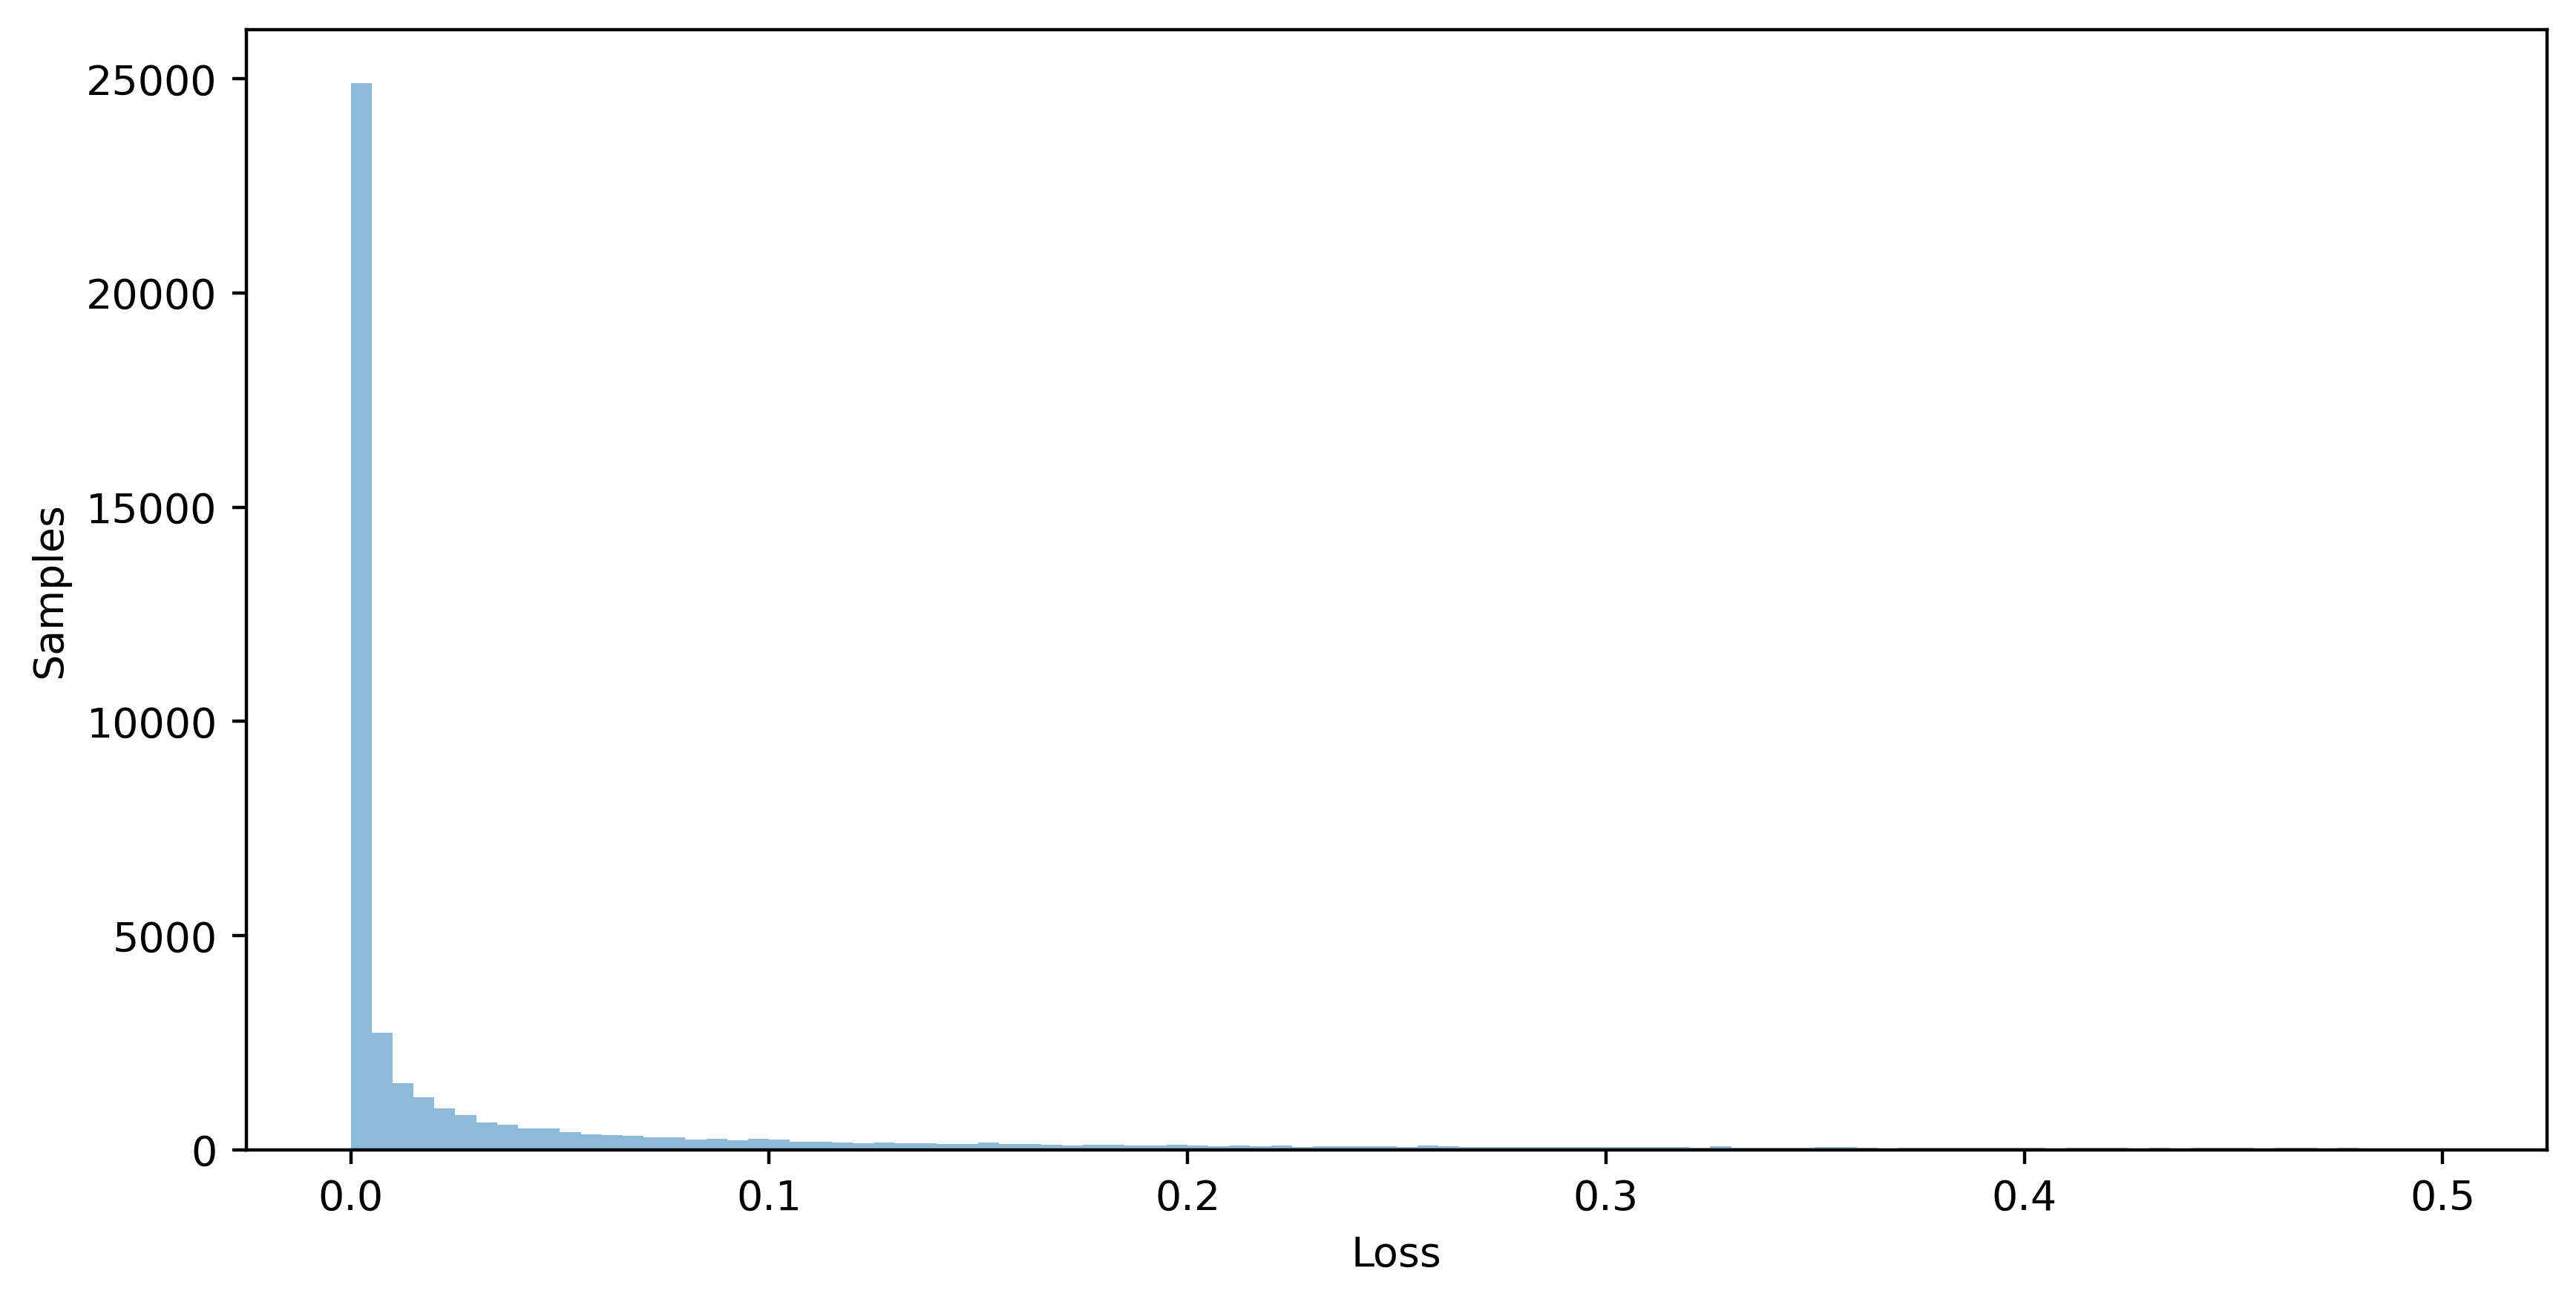

In [12]:
plt.figure(figsize=(10, 5), dpi=400)
plt.hist(losses[losses < 0.5], bins=100, alpha=0.5)
plt.xlabel('Loss')
plt.ylabel('Samples')
plt.show()

## 3. Compression Loss

In [13]:
# from keras import layers as L

# inp = L.Input((32, 32, 3))

# x = L.Conv2D(16, (3, 3), activation='relu', padding='same', strides=(2, 2))(inp)
# x = L.Conv2D(16, (3, 3), activation='relu', padding='same', strides=(2, 2))(x)
# x = L.Conv2D(16, (3, 3), activation='relu', padding='same', strides=(2, 2))(x)
# x = L.Conv2D(32, (3, 3), activation='relu', padding='same', strides=(2, 2))(x)
# x = L.Conv2D(32, (3, 3), activation='relu', padding='same', strides=(2, 2))(x)
# x = L.Conv2DTranspose(32, (3, 3), activation='relu', padding='same', strides=(2, 2))(x)
# x = L.Conv2DTranspose(32, (3, 3), activation='relu', padding='same', strides=(2, 2))(x)
# x = L.Conv2DTranspose(16, (3, 3), activation='relu', padding='same', strides=(2, 2))(x)
# x = L.Conv2DTranspose(16, (3, 3), activation='relu', padding='same', strides=(2, 2))(x)
# x = L.Conv2DTranspose(3, (3, 3), activation='sigmoid', padding='same', strides=(2, 2))(x)

# model = keras.models.Model(inputs=inp, outputs=x)
# model.summary()

In [14]:
# model.compile(optimizer='adam', loss='mse', metrics=['mae'])
# model.fit(scaled_X_train, scaled_X_train, epochs=10)

In [15]:
# pred = model.predict(scaled_X_train[:5])

# plt.figure(figsize=(5, 2), dpi=400)
# for i in range(5):
#     plt.subplot(2, 5, i+1)
#     plt.imshow(X_train[i])
#     plt.axis('off')
# for i in range(5):
#     plt.subplot(2, 5, 5+i+1)
#     plt.imshow(pred[i])
#     plt.axis('off')
# plt.show()

In [16]:
from keras import layers as L

NUM_DOWN_BLOCKS = 3
FILTER_EXP = 4
LATENT_EXP = 7

inp = L.Input((32, 32, 3))
x = inp
for i in range(NUM_DOWN_BLOCKS):
    x = L.Conv2D(2**FILTER_EXP, (3, 3), activation='relu', padding='same')(x)
    x = L.Conv2D(2**FILTER_EXP, (3, 3), activation='relu', padding='same')(x)
    x = L.MaxPooling2D((2, 2))(x)
x = L.Flatten()(x)
x = L.Dense(2**LATENT_EXP, activation='relu')(x)
x = L.Dense((32 // 2 ** NUM_DOWN_BLOCKS)**2 * (2**FILTER_EXP), activation='relu')(x)
x = L.Reshape((32 // 2 ** NUM_DOWN_BLOCKS, 32 // 2 ** NUM_DOWN_BLOCKS, -1))(x)
for i in range(NUM_DOWN_BLOCKS):
    x = L.Conv2D(2**FILTER_EXP,
                        (3, 3), activation='relu', padding='same')(x)
    x = L.Conv2D(2**FILTER_EXP,
                        (3, 3), activation='relu', padding='same')(x)
    x = L.UpSampling2D((2, 2))(x)
x = L.Conv2D(2**FILTER_EXP, (3, 3), activation='relu', padding='same')(x)
out = L.Conv2D(3, (1, 1), activation='sigmoid', padding='same')(x)

model = keras.models.Model(inputs=inp, outputs=out)

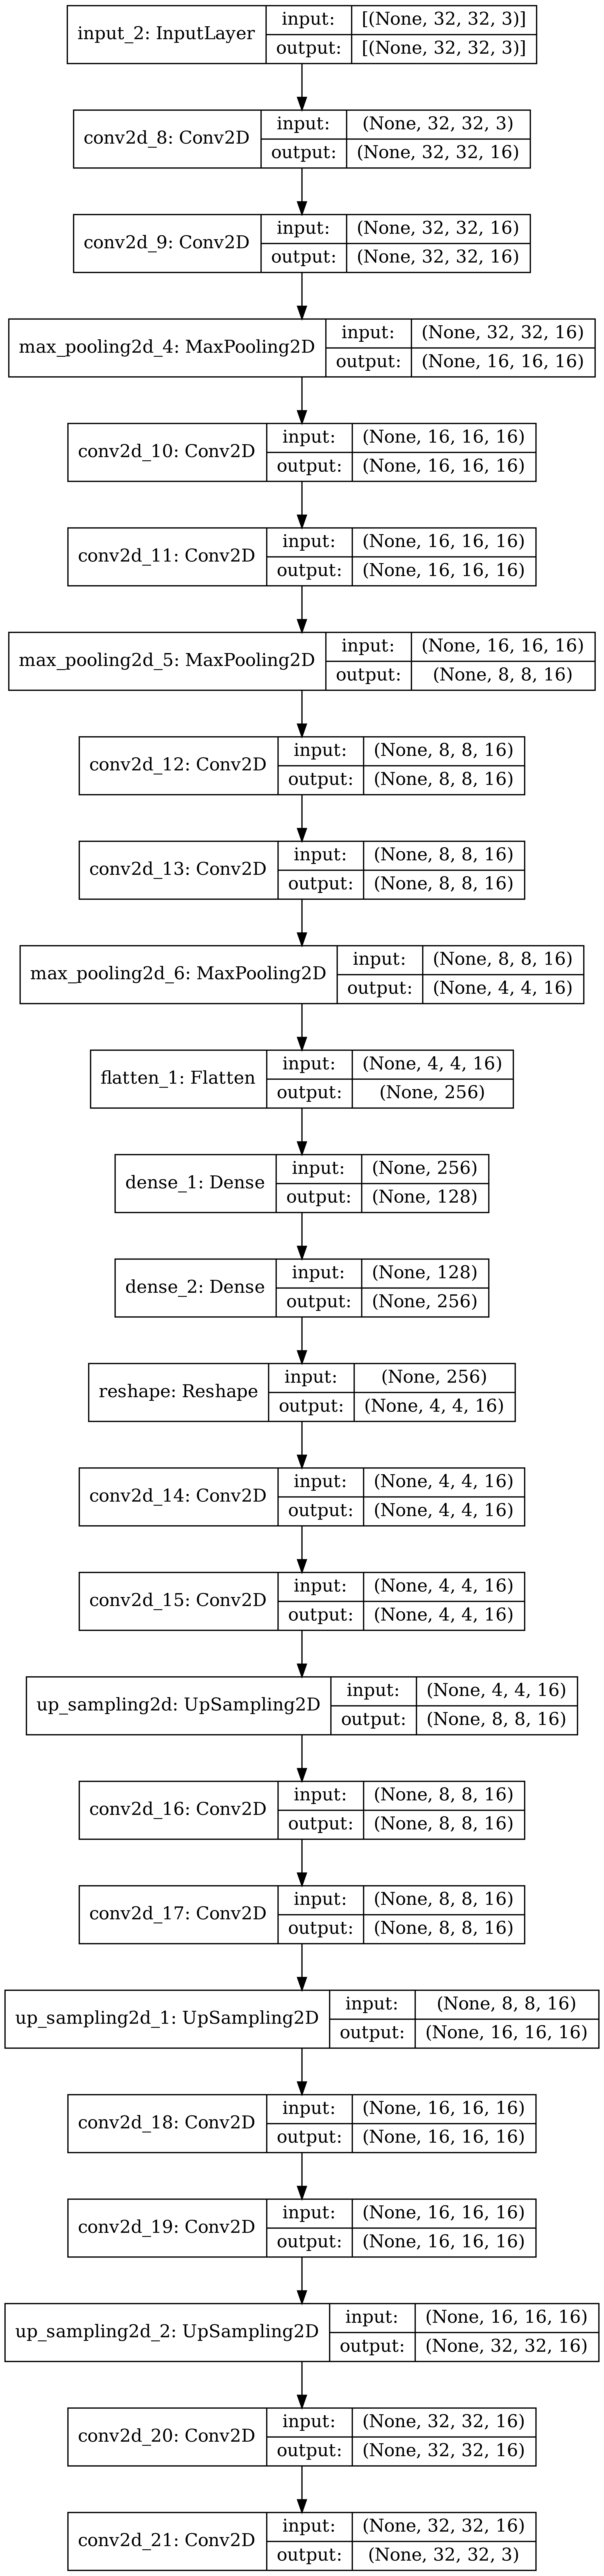

In [17]:
keras.utils.plot_model(model, show_shapes=True, dpi=400)

In [18]:
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 32, 32, 16)        448       
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 32, 32, 16)        2320      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 16, 16, 16)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 16, 16, 16)        2320      
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 16, 16, 16)        2320      
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 8, 8, 16)          0   

In [19]:
# scaled_X_train = X_train / 255

model.compile(optimizer='adam', loss='mse', metrics=['mae'])
model.fit(scaled_X_train, scaled_X_train, epochs = 30)

Epoch 1/30
1563/1563 [==============================] - 12s 7ms/step - loss: 0.0245 - mae: 0.1190
Epoch 2/30
1563/1563 [==============================] - 11s 7ms/step - loss: 0.0177 - mae: 0.1004
Epoch 3/30
1563/1563 [==============================] - 11s 7ms/step - loss: 0.0145 - mae: 0.0890
Epoch 4/30
1563/1563 [==============================] - 12s 7ms/step - loss: 0.0133 - mae: 0.0846
Epoch 5/30
1563/1563 [==============================] - 11s 7ms/step - loss: 0.0125 - mae: 0.0819
Epoch 6/30
1563/1563 [==============================] - 11s 7ms/step - loss: 0.0119 - mae: 0.0798
Epoch 7/30
1563/1563 [==============================] - 11s 7ms/step - loss: 0.0115 - mae: 0.0782
Epoch 8/30
1563/1563 [==============================] - 11s 7ms/step - loss: 0.0112 - mae: 0.0771
Epoch 9/30
1563/1563 [==============================] - 11s 7ms/step - loss: 0.0109 - mae: 0.0761
Epoch 10/30
1563/1563 [==============================] - 11s 7ms/step - loss: 0.0106 - mae: 0.0750
Epoch 11/30
1563/15

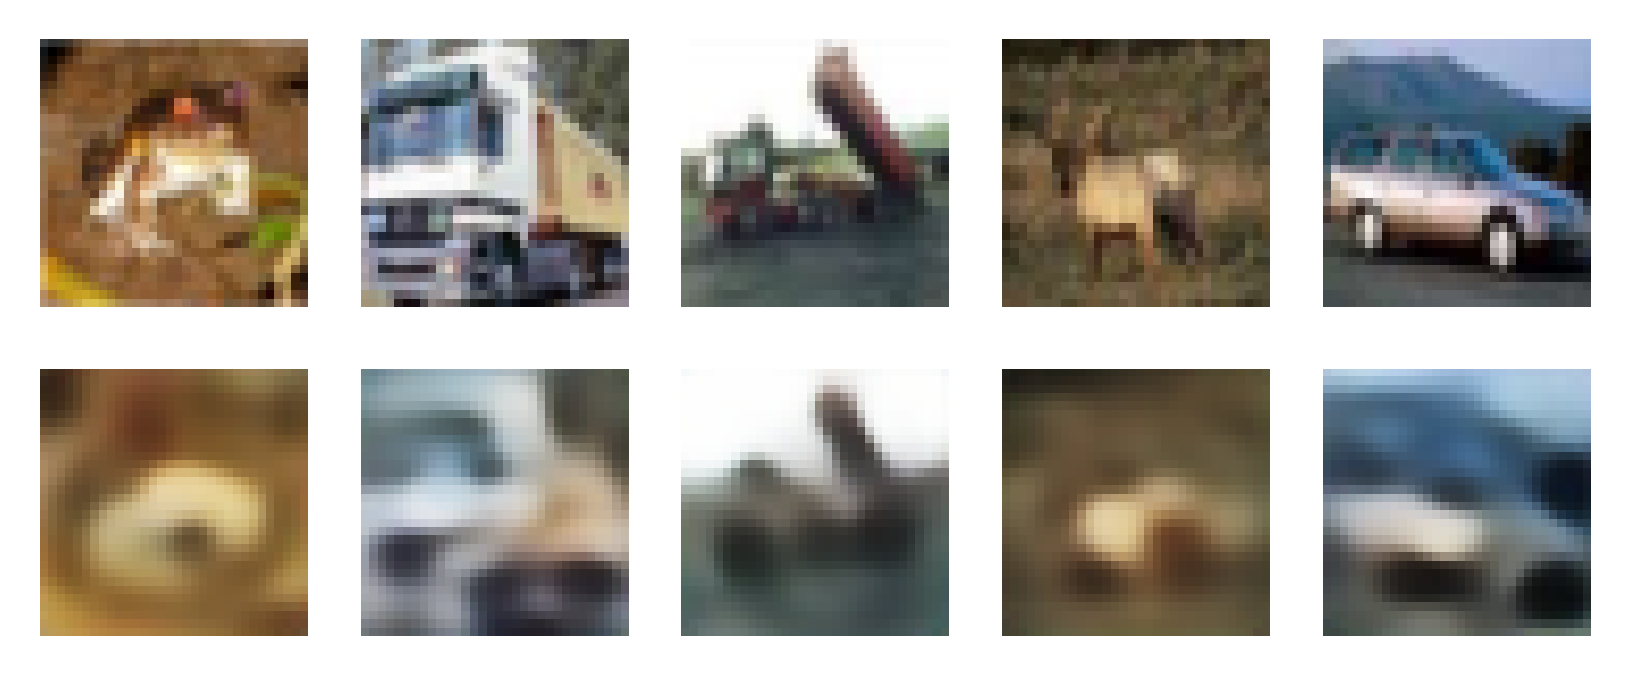

In [20]:
pred = model.predict(scaled_X_train[:5])

plt.figure(figsize=(5, 2), dpi=400)
for i in range(5):
    plt.subplot(2, 5, i+1)
    plt.imshow(X_train[i])
    plt.axis('off')
for i in range(5):
    plt.subplot(2, 5, 5+i+1)
    plt.imshow(pred[i])
    plt.axis('off')
plt.show()
plt.close()

In [21]:
scce = keras.losses.MeanAbsoluteError(reduction='none')
losses = scce(scaled_X_train, model.predict(scaled_X_train)).numpy()
losses = np.mean(losses, axis=(1, 2))

2022-12-11 20:38:01.148961: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 1228800000 exceeds 10% of free system memory.


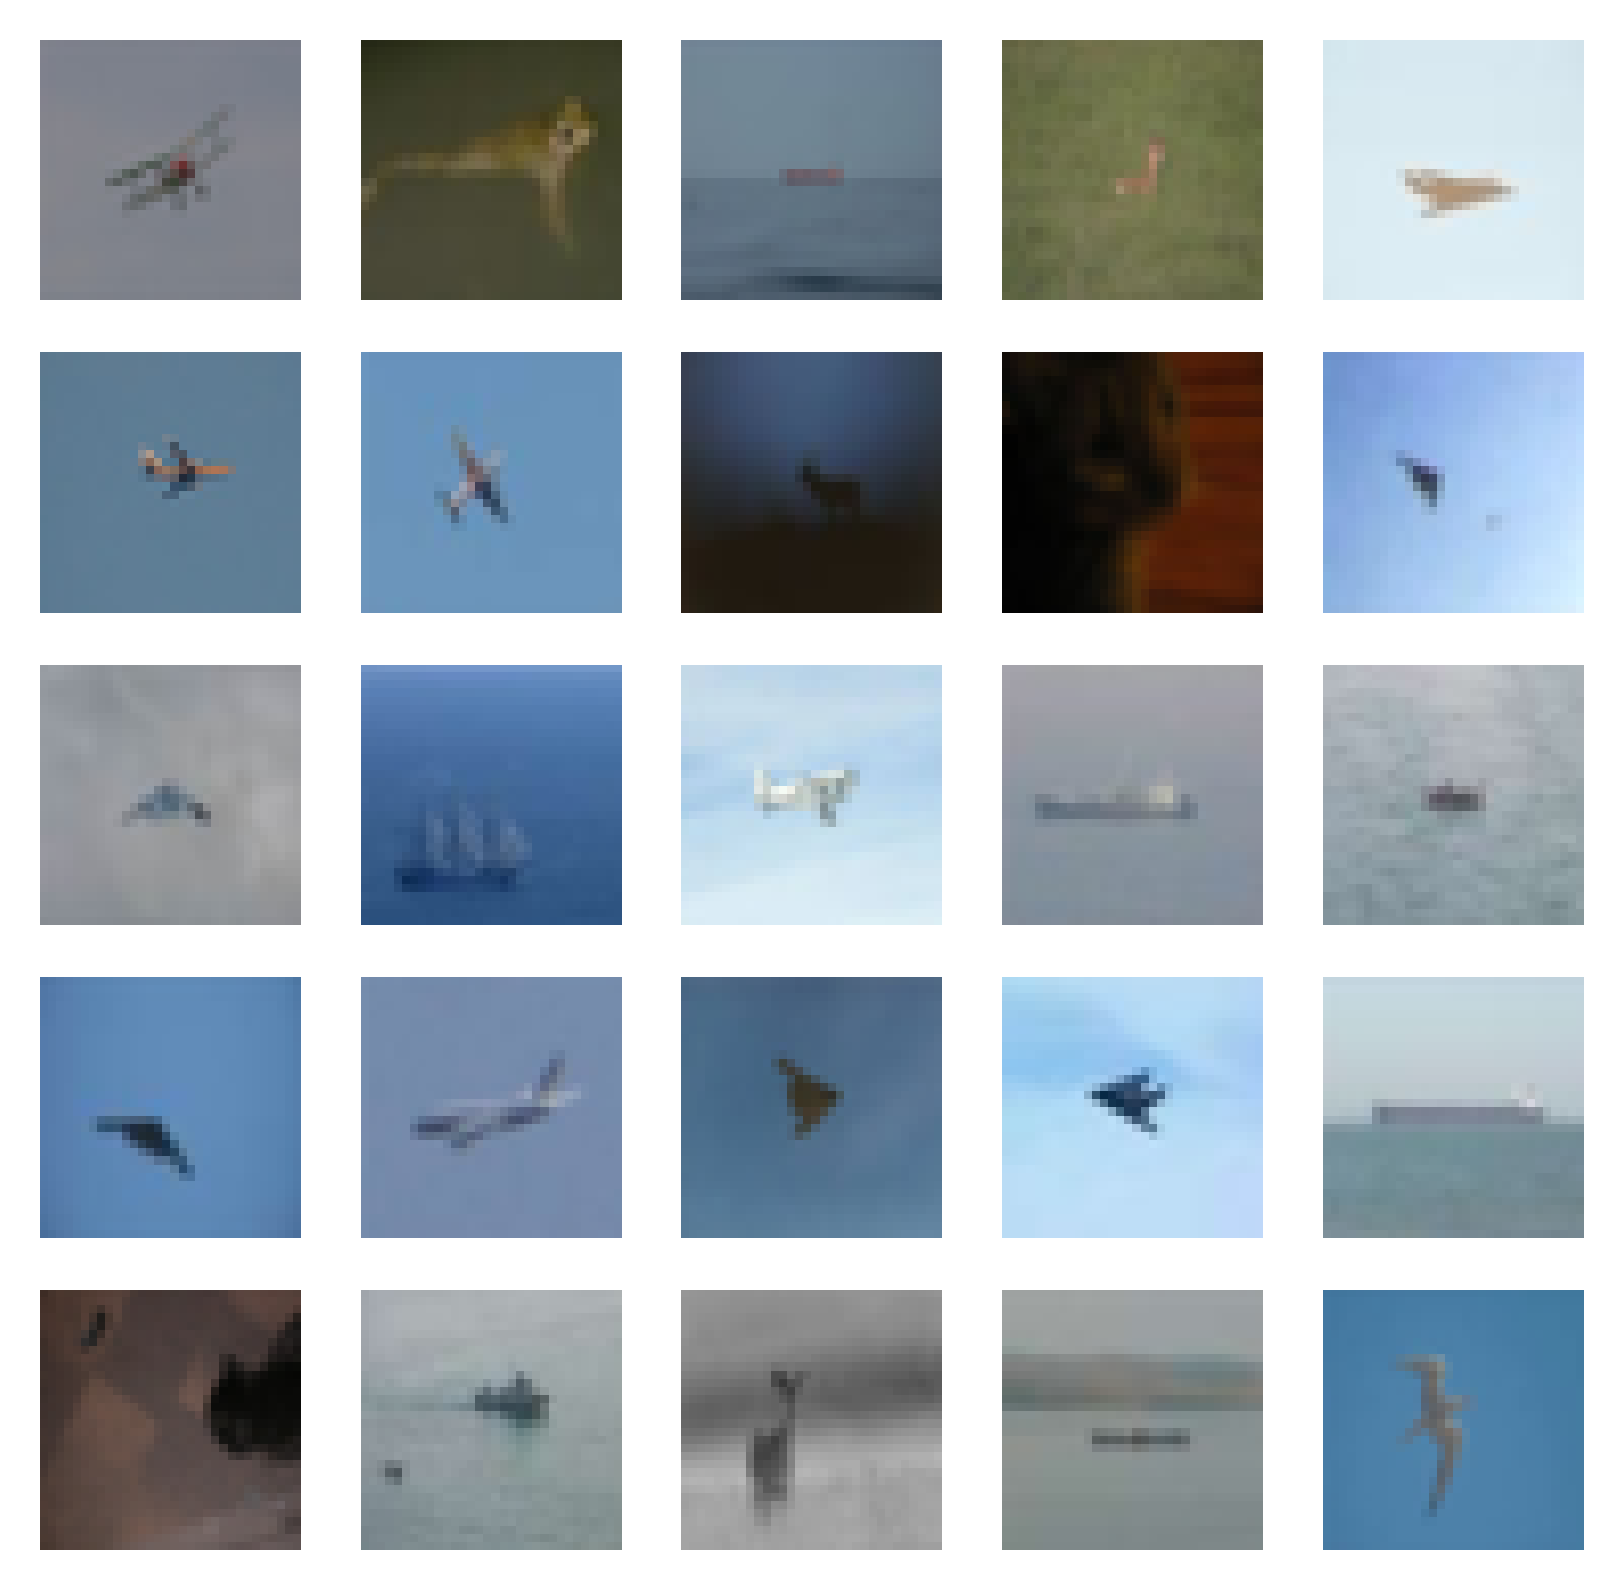

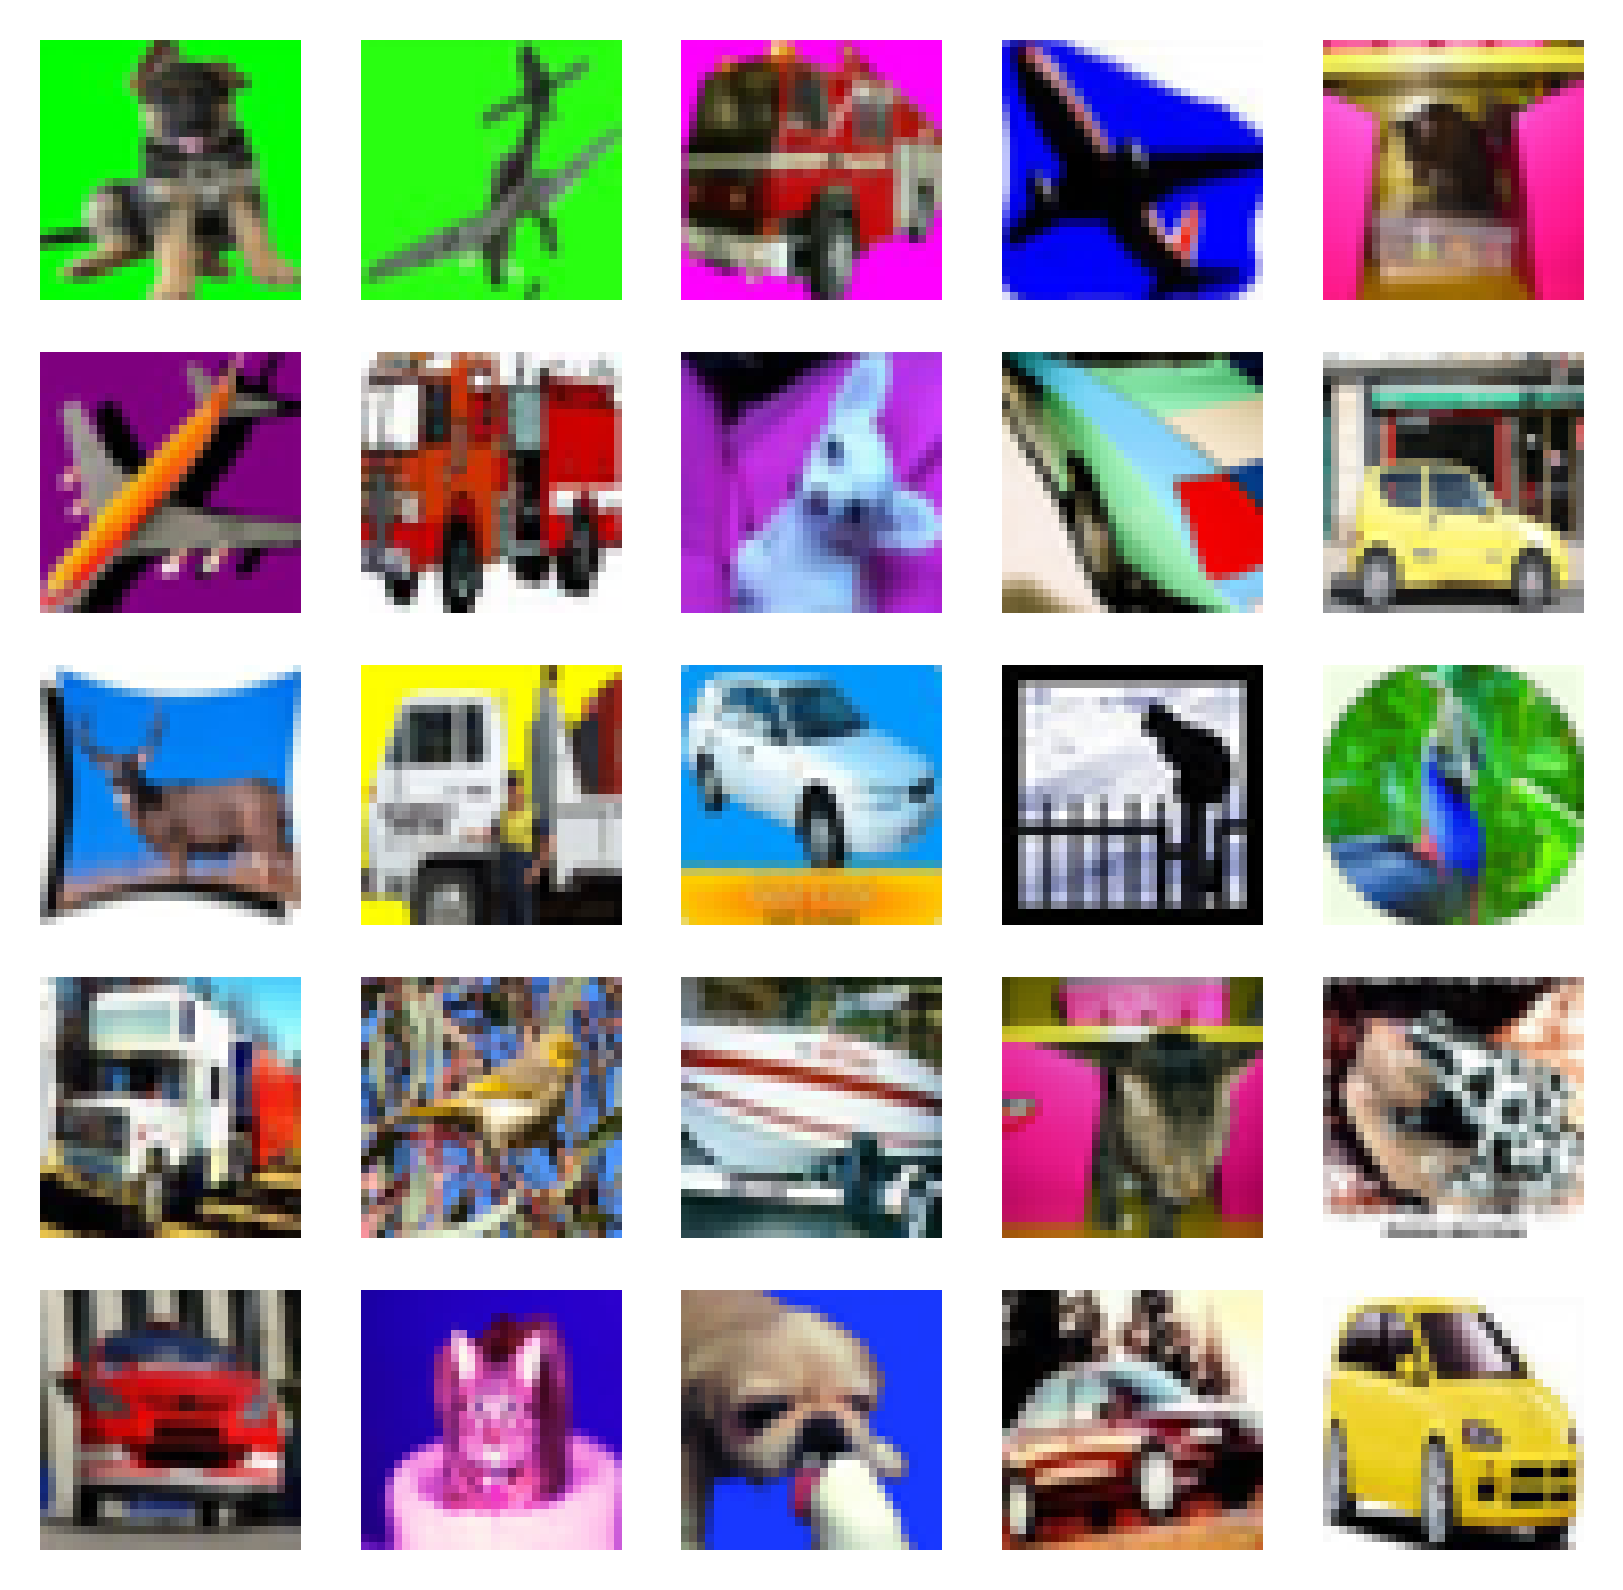

In [22]:
order_X_train = X_train[np.argsort(losses)]
order_losses = losses[np.argsort(losses)]

plt.figure(figsize=(5, 5), dpi=400)
for i in range(5):
    for j in range(5):
        plt.subplot(5, 5, i*5 + j + 1)
        plt.imshow(order_X_train[i*5 + j])
        plt.axis('off')
plt.show()
plt.close()

plt.figure(figsize=(5, 5), dpi=400)
for i in range(5):
    for j in range(5):
        plt.subplot(5, 5, i*5 + j + 1)
        plt.imshow(order_X_train[- (i*5 + j + 1)])
        plt.axis('off')
plt.show()
plt.close()

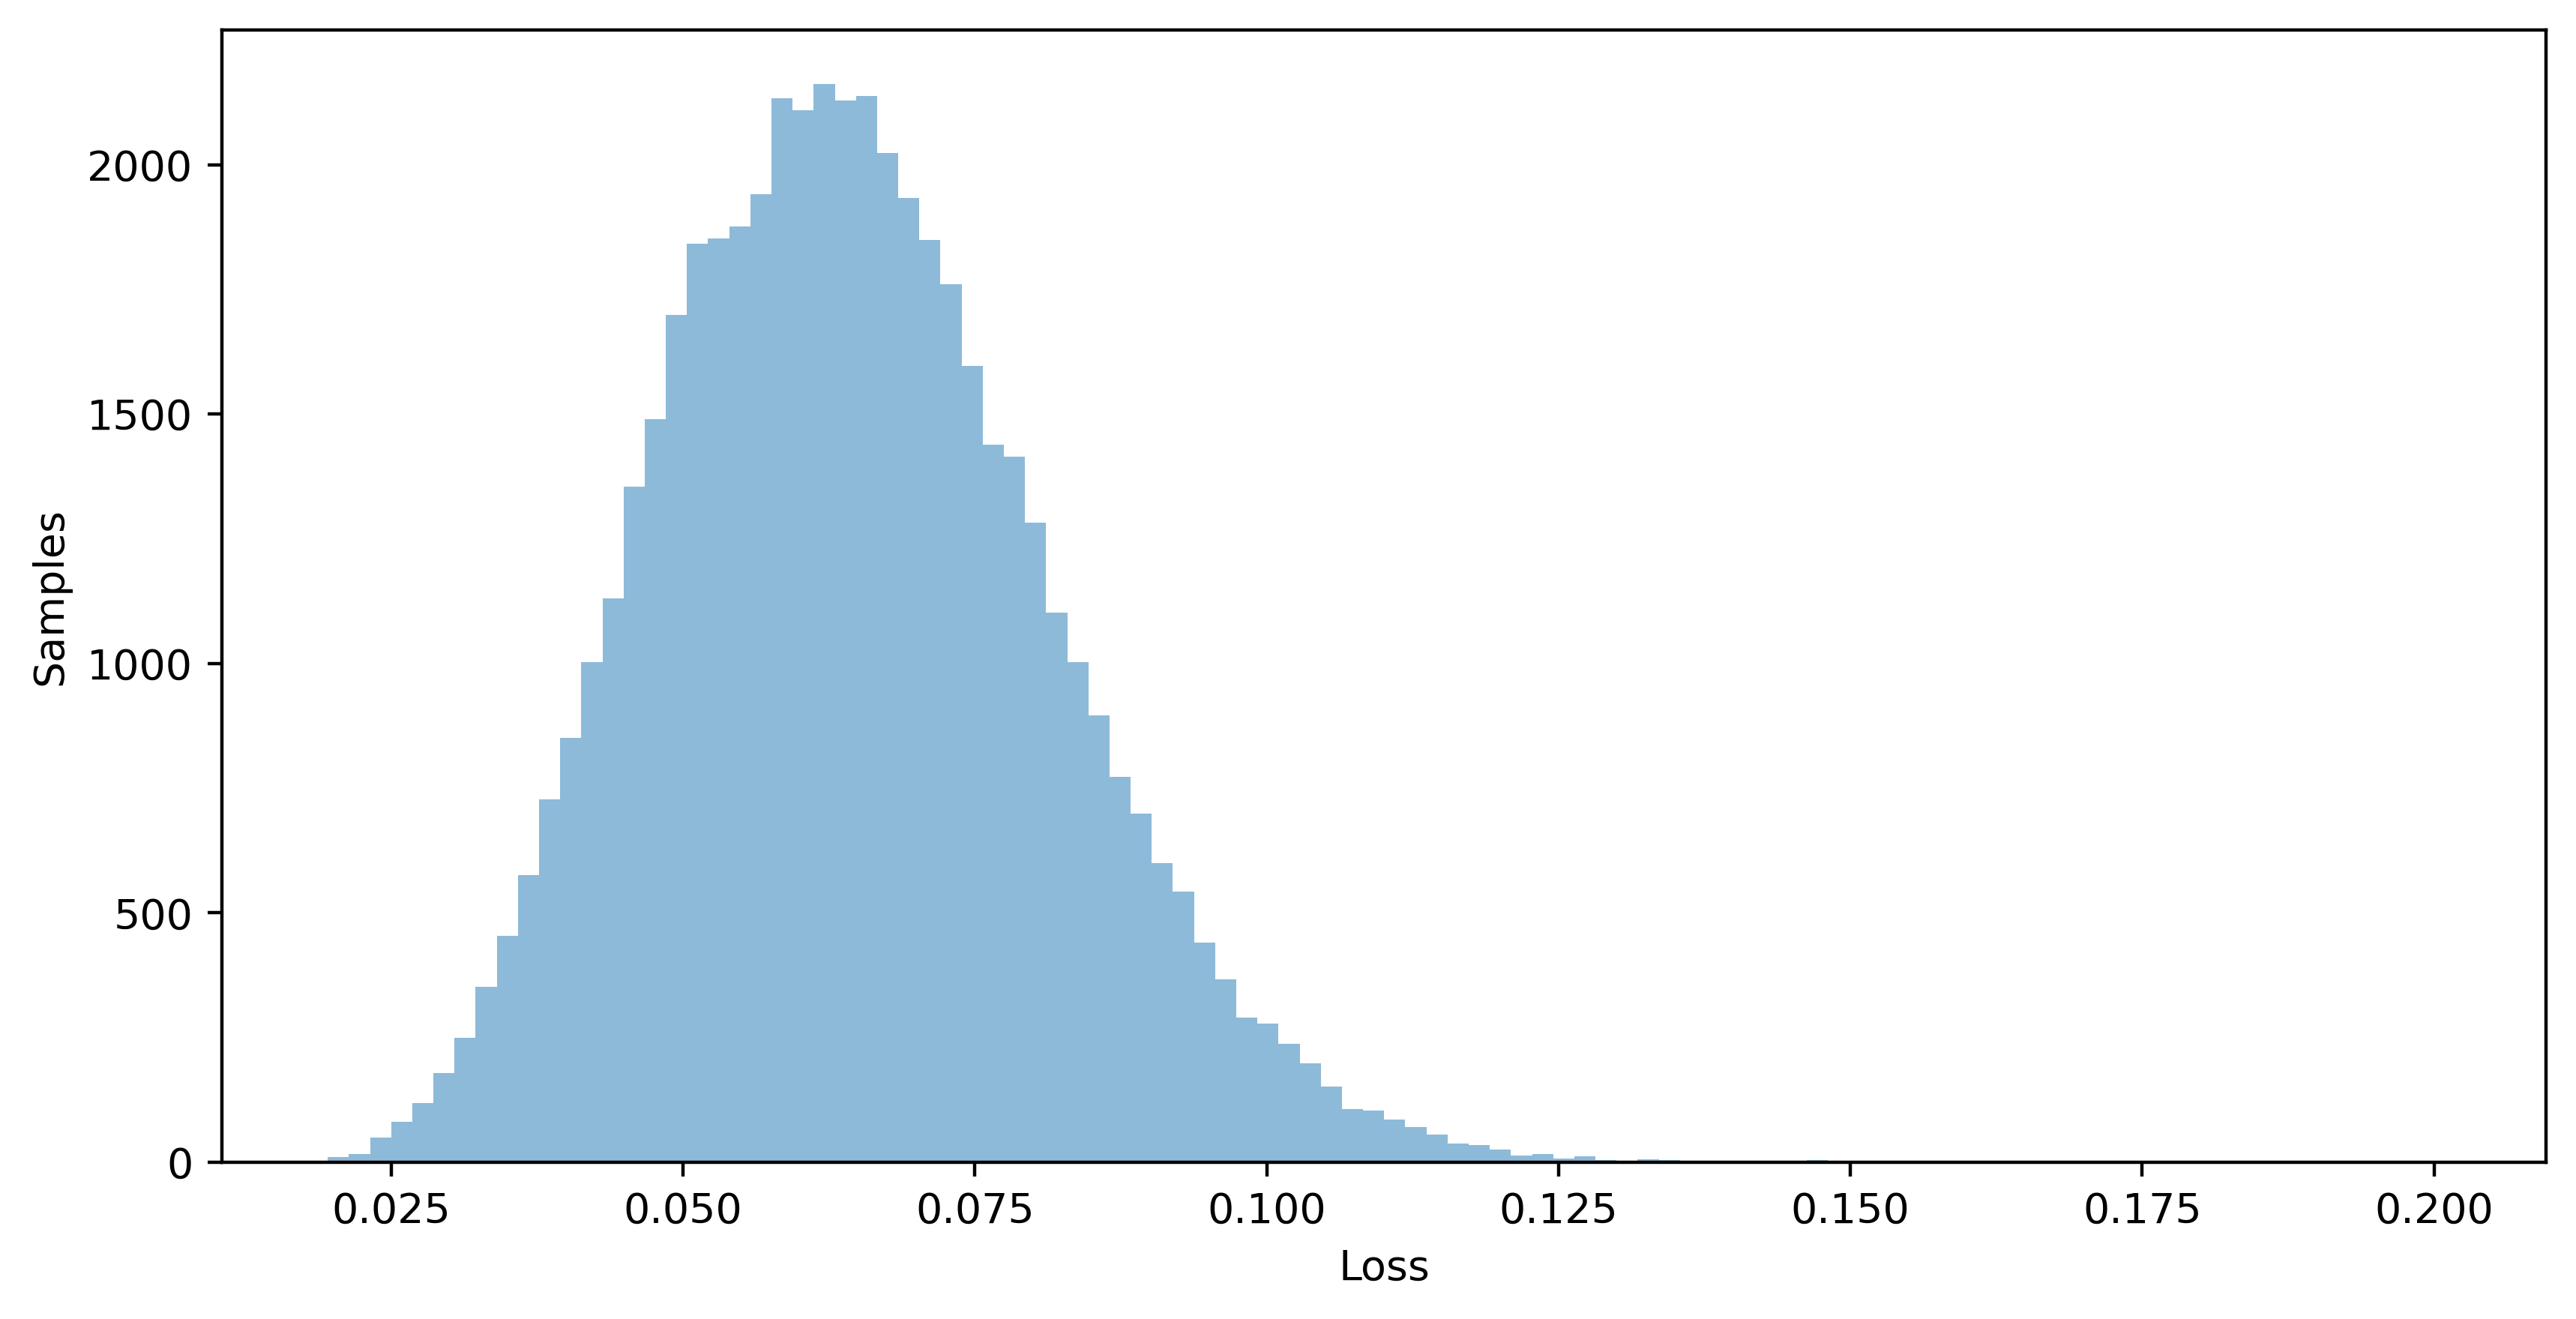

In [23]:
plt.figure(figsize=(10, 5), dpi=400)
plt.hist(losses, bins=100, alpha=0.5)
plt.xlabel('Loss')
plt.ylabel('Samples')
plt.show()

## 4. Prototypicality

In [24]:
from keras import layers as L

NUM_BLOCKS = 4
STARTING_EXP = 3

inp = L.Input((32, 32, 3))
x = inp
for i in range(NUM_BLOCKS):
    x = L.Conv2D(2**(i+STARTING_EXP), (3, 3), activation='relu', padding='same')(x)
    x = L.Conv2D(2**(i+STARTING_EXP), (3, 3), activation='relu', padding='same')(x)
    x = L.MaxPooling2D((2, 2))(x)
x = L.Flatten()(x)
out = L.Dense(10, activation='softmax')(x)

model = keras.models.Model(inputs=inp, outputs=out)

In [25]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.fit(X_train, y_train, epochs=30, validation_data=(X_test, y_test))

Epoch 1/30
1563/1563 [==============================] - 9s 6ms/step - loss: 1.6834 - accuracy: 0.3941 - val_loss: 1.3893 - val_accuracy: 0.4918
Epoch 2/30
1563/1563 [==============================] - 8s 5ms/step - loss: 1.3073 - accuracy: 0.5303 - val_loss: 1.2181 - val_accuracy: 0.5677
Epoch 3/30
1563/1563 [==============================] - 8s 5ms/step - loss: 1.1651 - accuracy: 0.5865 - val_loss: 1.2817 - val_accuracy: 0.5443
Epoch 4/30
1563/1563 [==============================] - 8s 5ms/step - loss: 1.0680 - accuracy: 0.6240 - val_loss: 1.1862 - val_accuracy: 0.5888
Epoch 5/30
1563/1563 [==============================] - 8s 5ms/step - loss: 1.0069 - accuracy: 0.6449 - val_loss: 1.1260 - val_accuracy: 0.6143
Epoch 6/30
1563/1563 [==============================] - 8s 5ms/step - loss: 0.9563 - accuracy: 0.6617 - val_loss: 1.0718 - val_accuracy: 0.6217
Epoch 7/30
1563/1563 [==============================] - 8s 5ms/step - loss: 0.9196 - accuracy: 0.6762 - val_loss: 1.0959 - val_accuracy:

In [26]:
embed_model = keras.models.Model(model.input, model.layers[-2].output)

In [27]:
embeddings = embed_model.predict(X_train)

In [28]:
from sklearn.cluster import KMeans
cluster = KMeans(n_clusters=10, random_state=0, init='k-means++')
cluster.fit(embeddings)

KMeans(n_clusters=10, random_state=0)

In [29]:
centers = cluster.cluster_centers_

In [30]:
from scipy.spatial.distance import cosine

In [31]:
distances = []
for sample in tqdm(embeddings):
    distances.append(min([cosine(sample, centroid) for centroid in centers]))

  0%|          | 0/50000 [00:00<?, ?it/s]

In [32]:
distances = np.array(distances)

In [33]:
order_X_train = X_train[np.argsort(distances)]
order_distances = losses[np.argsort(distances)]

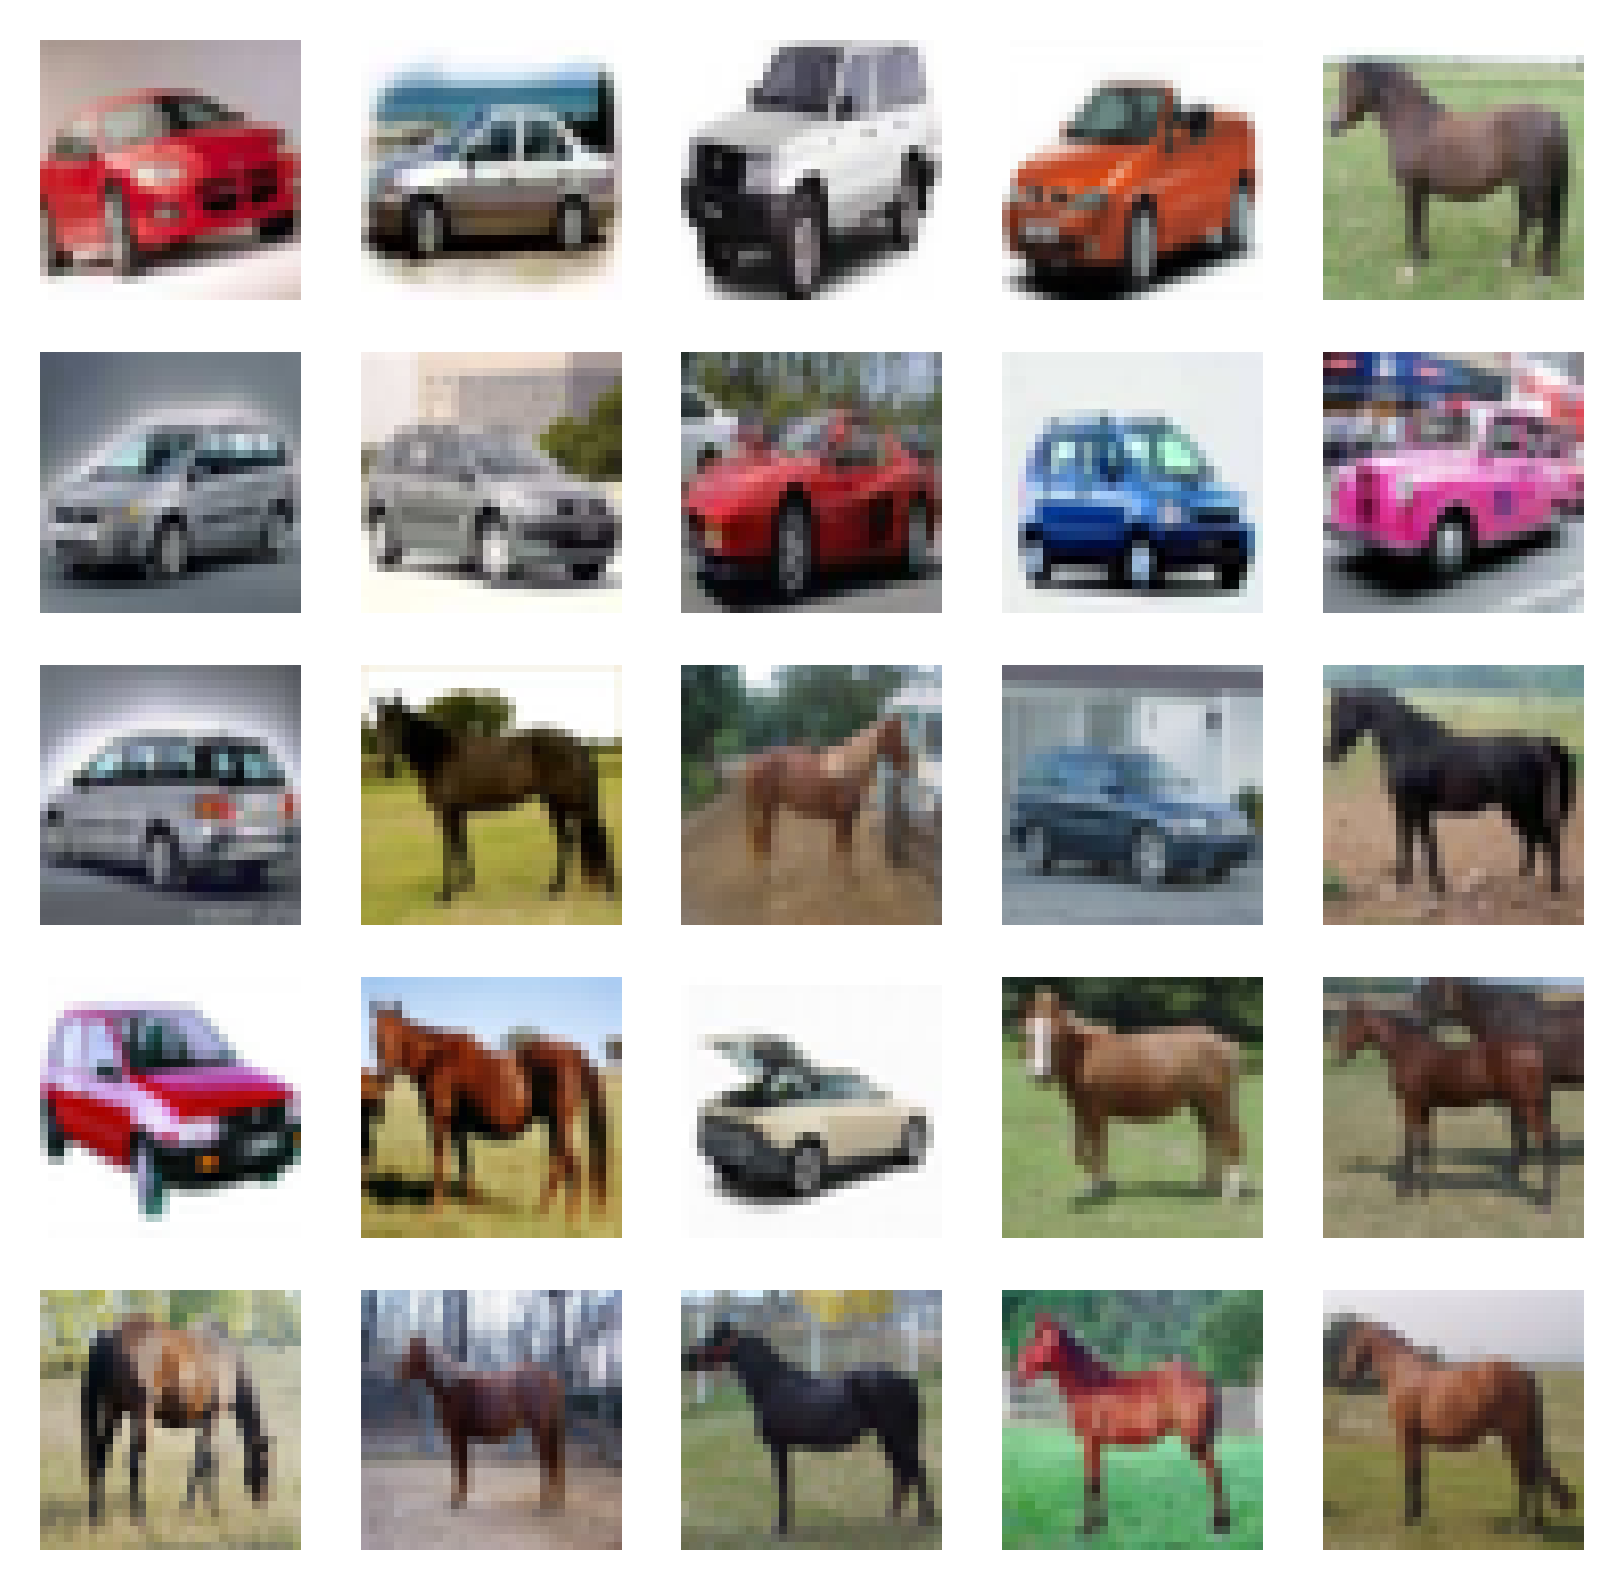

In [34]:
plt.figure(figsize=(5, 5), dpi=400)
for i in range(5):
    for j in range(5):
        plt.subplot(5, 5, i*5 + j + 1)
        plt.imshow(order_X_train[i*5 + j])
        plt.axis('off')
plt.show()
plt.close()

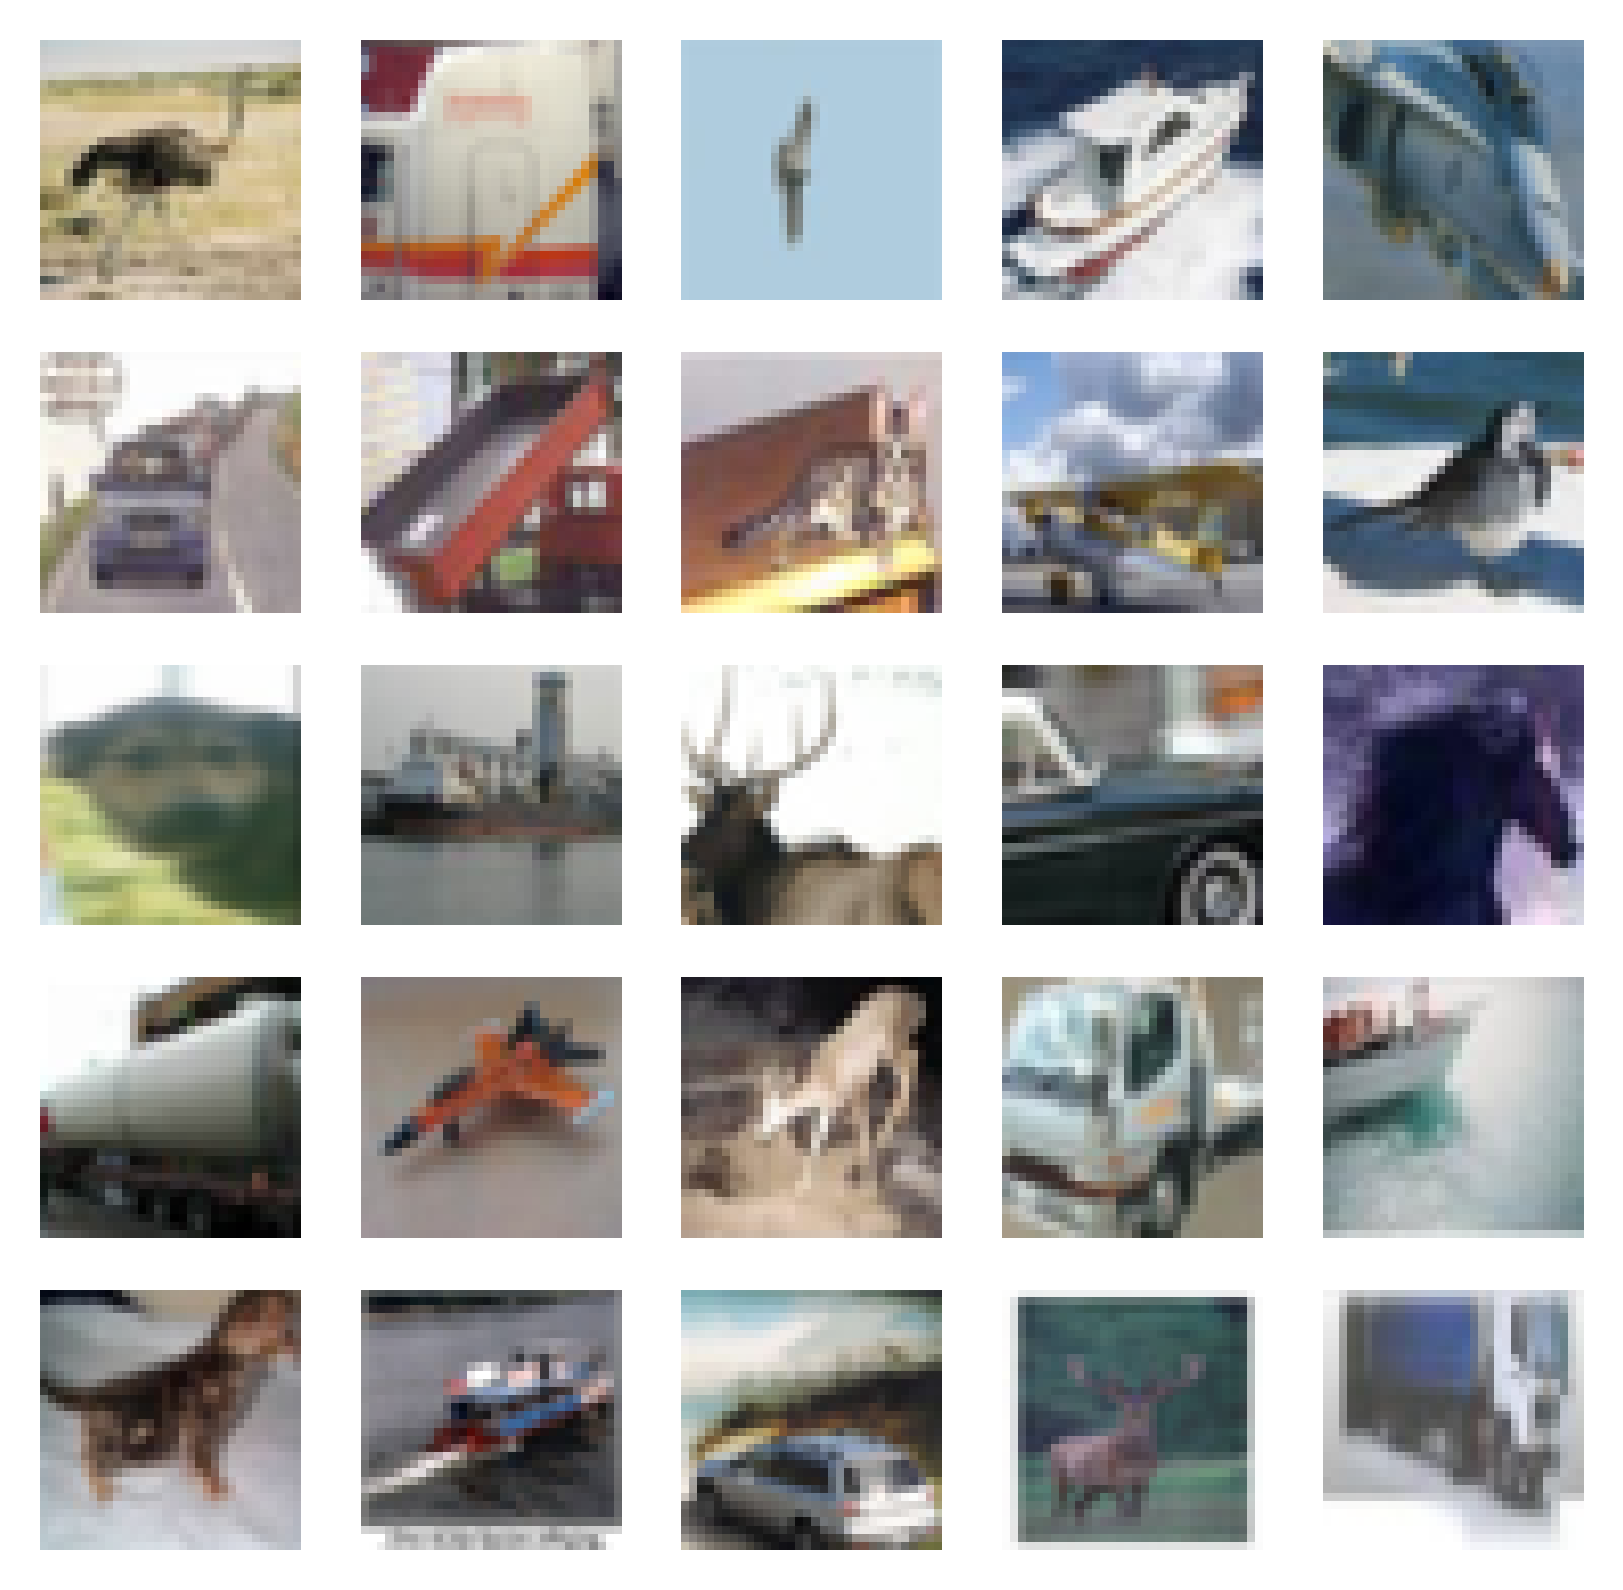

In [35]:
plt.figure(figsize=(5, 5), dpi=400)
for i in range(5):
    for j in range(5):
        plt.subplot(5, 5, i*5 + j + 1)
        plt.imshow(order_X_train[-(i*5 + j + 1)])
        plt.axis('off')
plt.show()
plt.close()

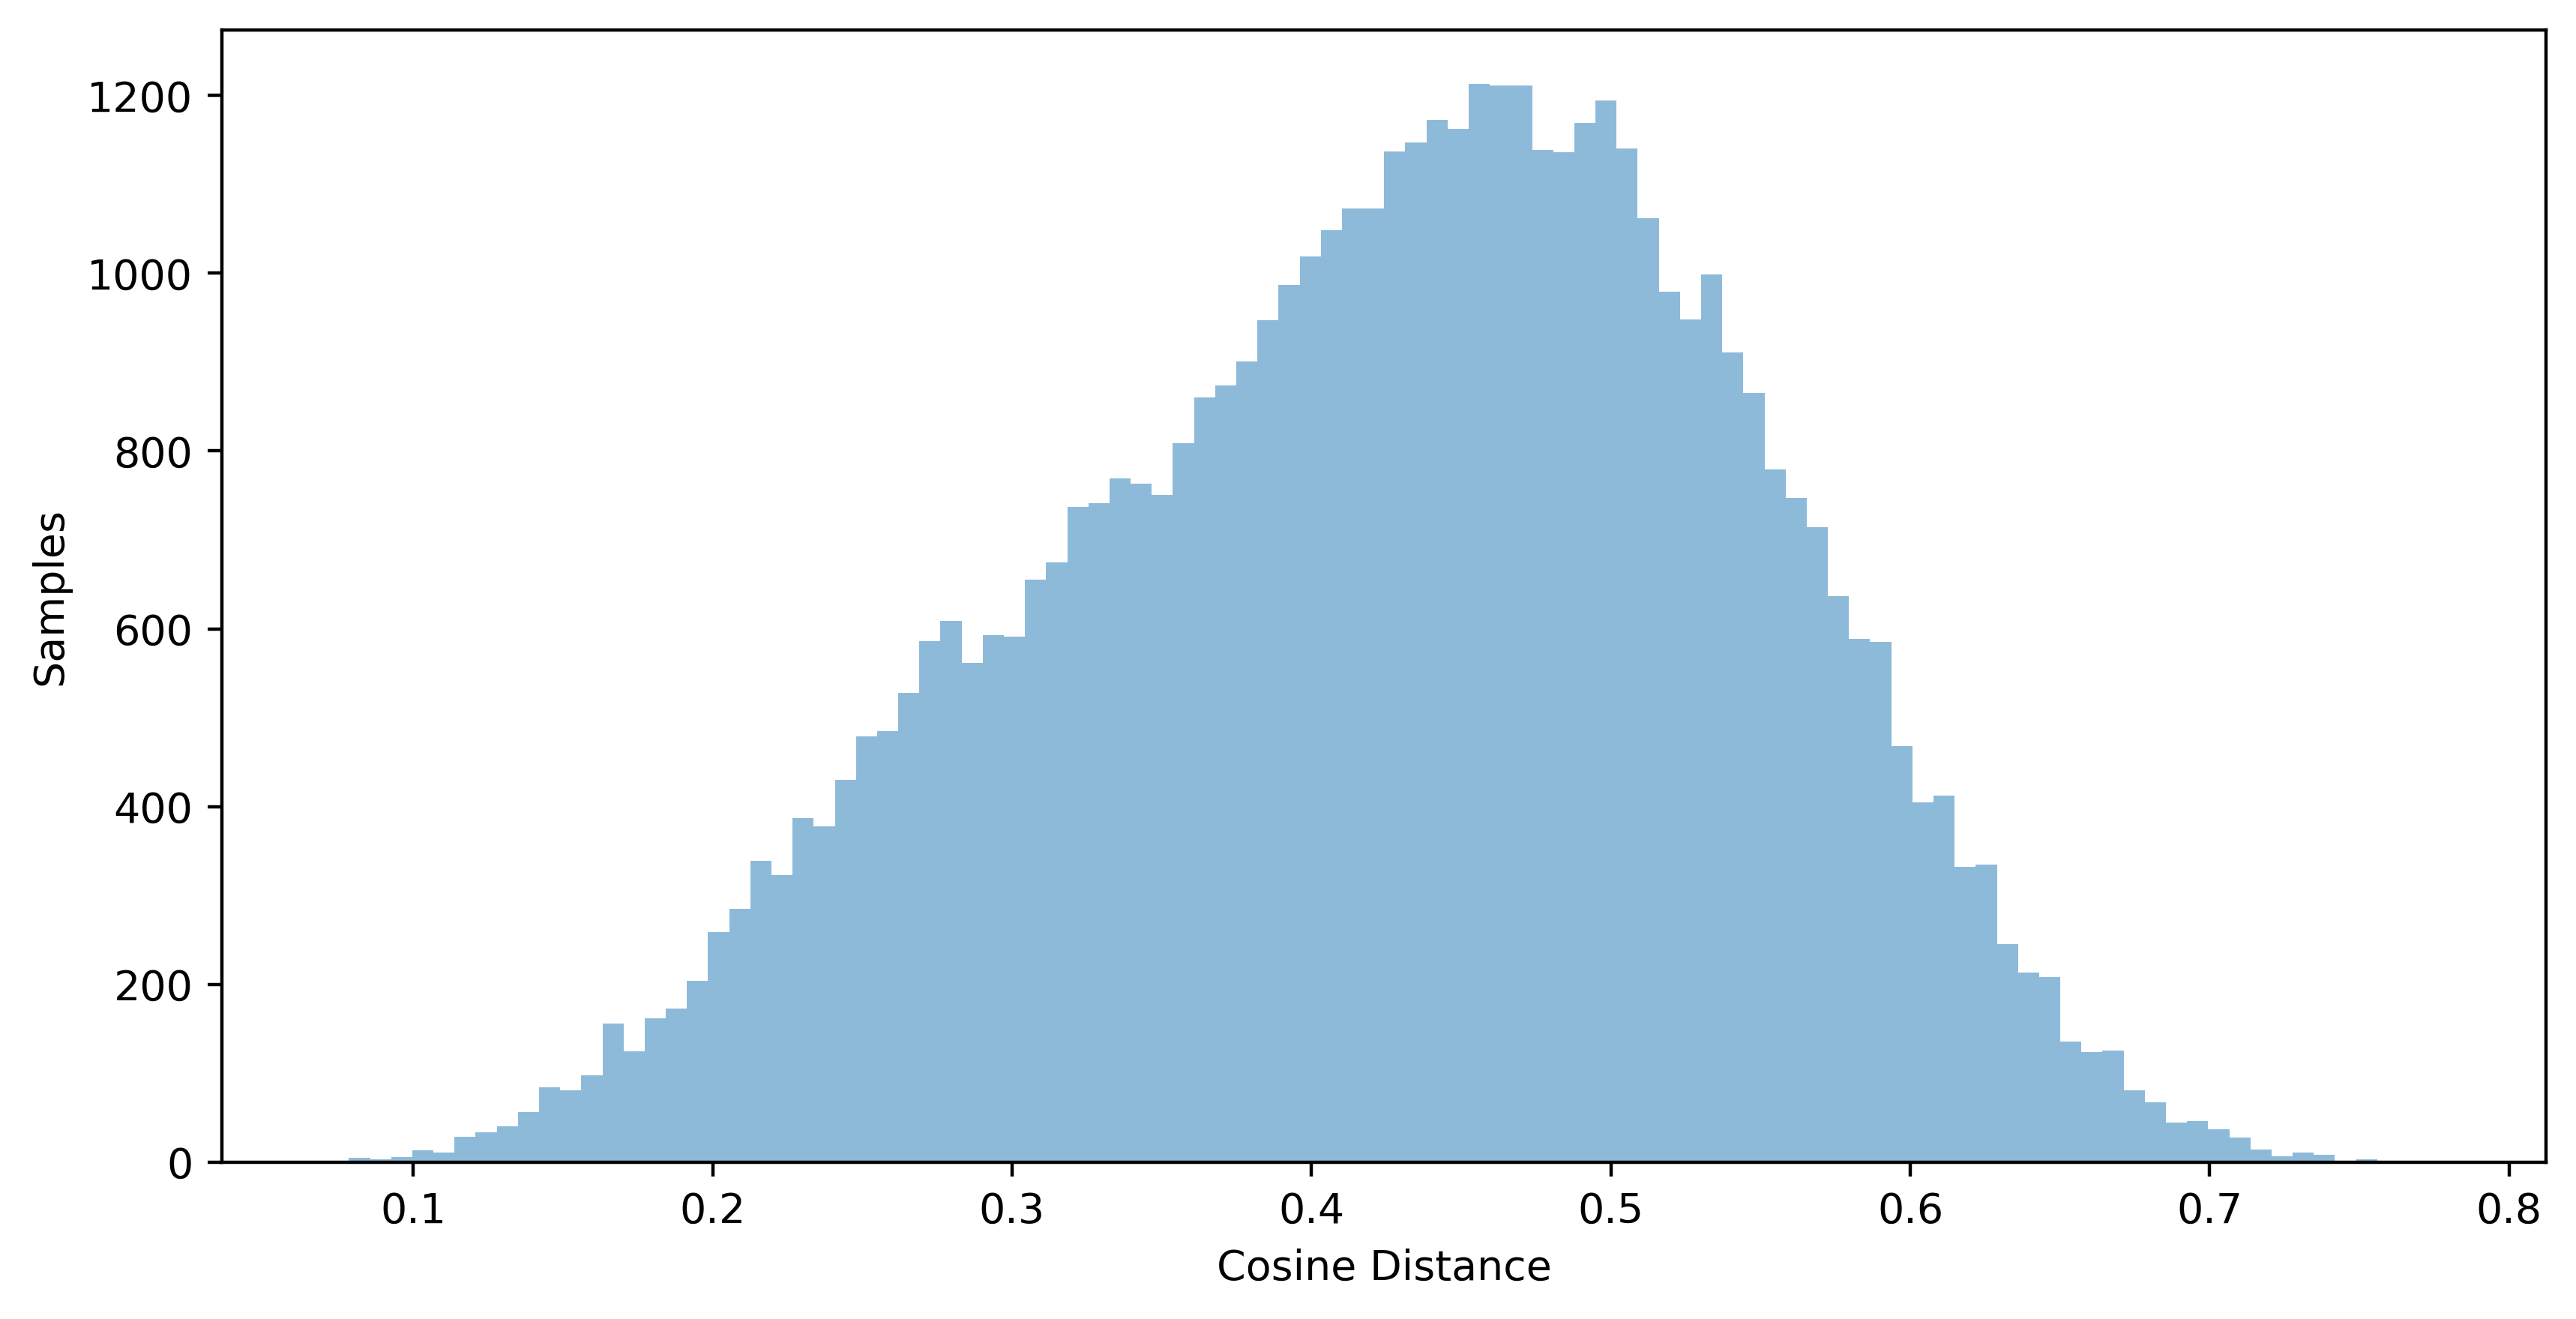

In [36]:
plt.figure(figsize=(10, 5), dpi=400)
plt.hist(distances, bins=100, alpha=0.5)
plt.xlabel('Cosine Distance')
plt.ylabel('Samples')
plt.show()